# TP2: A deeper understanding CNN denoising

### Name: **Elías Masquil**

The objective of this lesson is to study more in detail some of the top CNN image denoising algorithms. 

We will cover the following topics:
* Study some aspects of the DnCNN network
* Test FFDNet
* The role of the training loss
* Bias-free networks

There are <font color='blue'>**7 questions**</font> in the notebook and corresponding text areas to fill-in the answers. 

**Note that** some of the blocks of this notebook take up to three minutes to run on CPU.


#### Instructions
To solve this TP, answer the questions below. Then export the notebook with the answers using  the menu option **File->Download .ipynb**. Then **[submit your solution here](https://docs.google.com/forms/d/e/1FAIpQLScQZ6QQvsdihV5NqNBeVe35Cg1MnvjFFNum7o-v8Ody6dhpVA/viewform)** by 17/11/2021.  You will receive an acknowledgement of receipt.

In [2]:
# Setup code for the notebook

# Execute code 'cells' like this by clicking on the 'Run' 
# button or by pressing [shift] + [Enter].

# This cell only imports some python packages that will be
# used below. It doesn't generate any output. Something similar 
# applies to the next two or three cells. They only define 
# functions that are used later.


# This notebook can also run on colab (https://colab.research.google.com/)
# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files
    !pip install -q hdf5storage

    !rm -fr MVAdenoising
    !git clone --quiet https://github.com/gfacciol/MVAdenoising
    !cp -r MVAdenoising/* .

except ImportError:
    # %matplotlib notebook
    pass


# These are all the includes used through the notebook
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io # read and write images
import vistools        # image visualization toolbox


# global variable for setting the torch.load    map_location
if torch.cuda.is_available():
    loadmap = None
else:
    loadmap = {'cuda:0': 'cpu'}
    

# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

persistent_storage = 'trainings/'

     |████████████████████████████████| 53 kB 1.2 MB/s 


**A note about Colab.** The current notebook runs on a virtual machine with sessions limited to 24h. After that all the content of the session (state and files) is removed. So  a persistent storage must be connected to the virtual machine in order to store the results.

The following code  connects a google drive account to the virtual machine.

In [3]:
# this cell connects the persistent storage

persistent_storage = 'trainings/'
try:
    # Load the Drive helper and mount
    from google.colab import drive
    import os

    # This will prompt for authorization.
    drive.mount( 'Drive')
    persistent_storage = 'Drive/My Drive/CNN_trainings/'
    os.makedirs(persistent_storage, exist_ok=True)
except:
    pass

Mounted at Drive


-----------------------------

# DnCNN

We start by testing some aspects of the DnCNN architecture proposed in:

*K. Zhang, W. Zuo, Y. Chen, D. Meng, and L. Zhang, “Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising,” IEEE Trans. Image Process., vol. 26, no. 7, pp. 3142–3155, Jul. 2017.*

The network has several hidden layers, all of them equal: convolution, **batch normalization** and **ReLU activations** and uses **residual learning**. All convolutions have the same size (the authors used 3x3).

<img width=700 src="https://www.researchgate.net/profile/Yunjin_Chen/publication/306187437/figure/fig4/AS:667093628379148@1536058923422/The-architecture-of-the-proposed-DnCNN-network.png"/>


The module `models` declares the DnCNN network. An instance of the network for grayscale images is created with `model = DnCNN(1,1)` where the parameters `1` indicate the number of input and output channels.
The model is made of atomic blocks such as `nn.Conv2d`, whch represents a convolutional layer. Note how the layers are declared in the `__init__` method of each model and then called in `forward`. 


The implementation of DnCNN can be found in the `models/DnCNN.py` file. The model constructor can be called as follows:

```python
class DnCNN(nn.Module):
    '''PyTorch module for the DnCNN network.'''
    def __init__(self, in_channels=1, out_channels=1, num_layers=17, 
                 features=64, kernel_size=3, residual=True, bias=True):
        '''
        Constructor for a DnCNN network.

        Args:
            - in_channels: input image channels (default 1)
            - out_channels: output image channels (default 1)
            - num_layers: number of layers (default 17)
            - num_features: number of hidden features (default 64)
            - kernel_size: size of conv. kernel (default 3)
            - residual: use residual learning (default True)
            - bias: remove all Conv and BN biases (defalut True)

        Return: network with randomly initialized weights
        '''
```

A newly created network is initialized with random weights.
We also provide you with a function to load pretrained weights

```python
def DnCNN_pretrained(sigma=30, savefile=None, verbose=False, color=False):
    '''
    Loads the pretrained weights of DnCNN for grayscale and color images  
    from https://github.com/cszn/DnCNN.git

    Args:
        - sigma   : is the level of noise in range(10,76,5)
        - savefile: is the .pt file to save the model weights 
        - verbose : verbose output
        - color   : load the weights for the color networks

    Returns:
        - DnCNN(1,1) model with 17 layers with the pretrained weights    
        or
        - DnCNN(3,3) model with 20 layers with the pretrained weights     
    '''
```

### Recap from TP1 - training of a small DnCNN

In the last assignment of TP1 you were asked to train a small DnCNN network with the same receptive field and roughly the same number of parameters than a DCT denoiser with 8x8 patches.

In case you didn't do the assignment, you can now load a pre-trained network and compare its results with a pretrained Full DnCNN.

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set

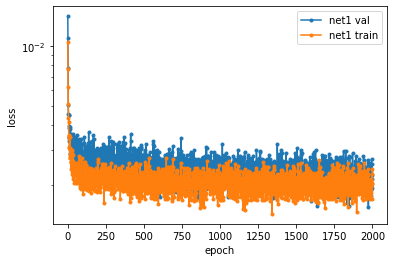

In [4]:
# compare the evolution of the loss
from models import DnCNN, CONV_BN_RELU

# load last checkpoint
sigma   = 30
net = torch.load('pre-trained-tp2/tiny_DnCNN_2000.pt', map_location=loadmap)

plt.semilogy(net[3], '.-', label='net1 val')
plt.semilogy(net[2], '.-', label='net1 train')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss');

Let's see the evolution of the results along the epochs for this tiny DnCNN, compare the result with the one of our best DCT denoising network, and with the DnCNN network trained by the authors.   

0 

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set

500 1000 1500 2000 downloading pretrained models



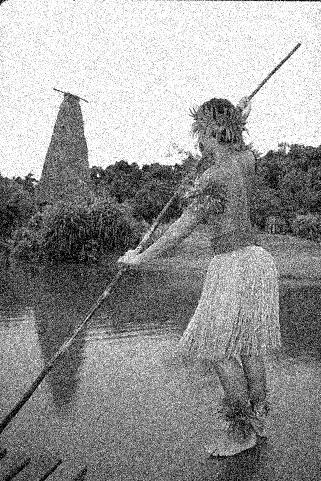
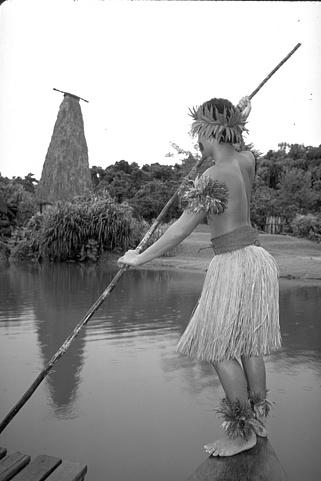
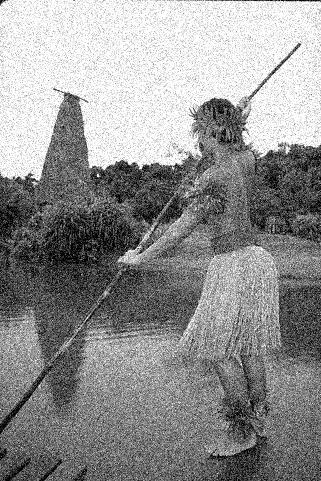
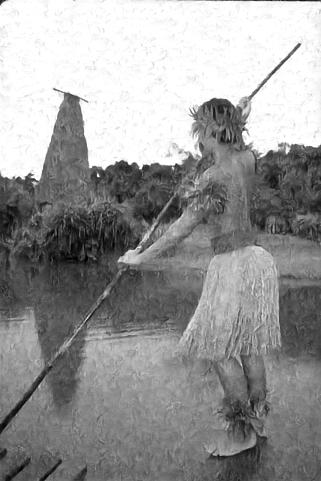
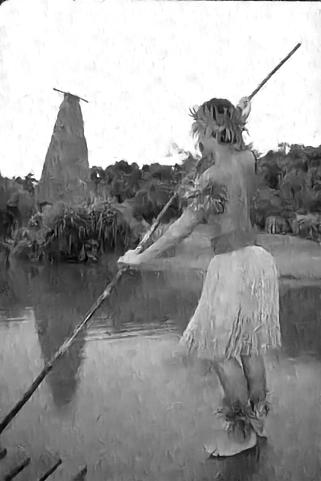
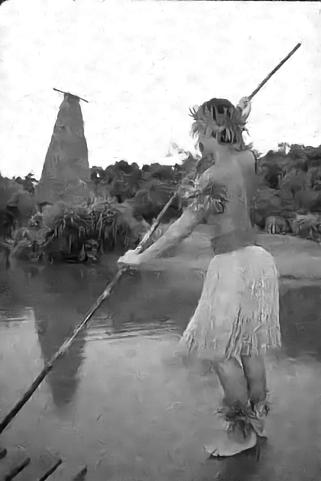
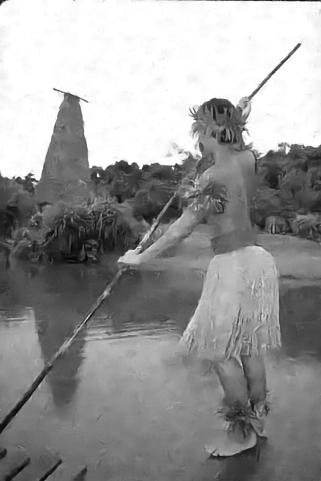
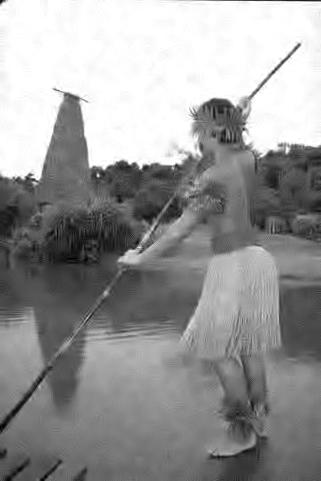
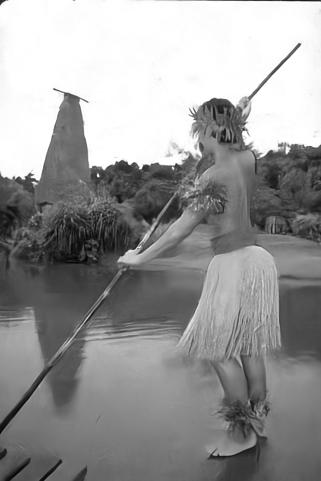

In [5]:
# evolution of the denoising performance during training
from denoising_helpers import test_denoiser, PSNR
from models import DCTlike, DnCNN_pretrained
from skimage import io
from vistools import unzip

# load an image and compute noisy one 
sigm = 30 
img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

# outputs list of pairs (image, text)
outs   = list()

# add noisy and clean images
outs.append( (img_noisy, 'noisy') )
outs.append( (img_clean, 'clean') )

# add results of iterations
for i in range(0,2001,500):
    print('%d '%i, end='')
    net = torch.load('pre-trained-tp2/tiny_DnCNN_%04d.pt' % i, map_location=loadmap)[0]
    out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
    outs.append( (out, 'trained tiny DnCNN - it %d - %f (dB)' % (i, PSNR(out, img_clean)) ) ) 


# add result of original dct
net = DCTlike(8, sigma, initializeDCT=True)
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'original dct - %f (dB)' % (PSNR(out, img_clean)) ) )

# add result of full DnCNN with trained weights
net = DnCNN_pretrained(sigma)
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'Full DnCNN - %f (dB)' % (PSNR(out, img_clean)) ) )


# show result as a gallery 
vistools.display_gallery(unzip(outs,0), unzip(outs,1))

# Stress tests on DnCNN: robustness to changes in $\sigma$

We will consider the DnCNN network trained for $\sigma = \sigma_0$ and see how it responds to changing $\sigma$. The following code applies noise of different standard deviation to an image and tests two networks: one trained for $\sigma_0$ and the other one using the network trained for the closest $\sigma$. The networks have been pretrained for $\sigma = 10, 15, ..., 70, 75$.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 


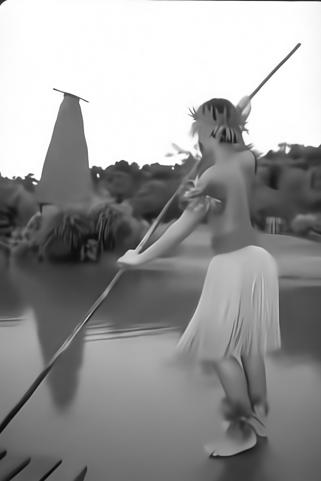
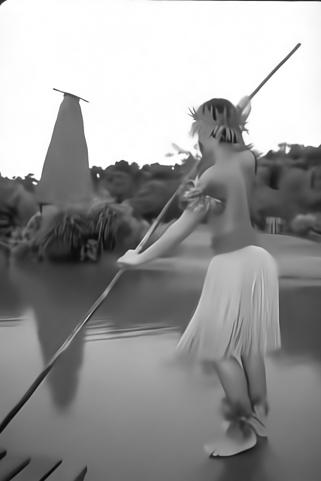
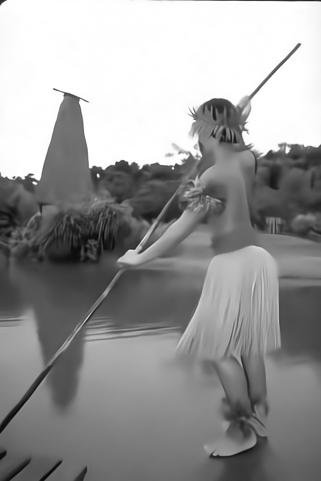
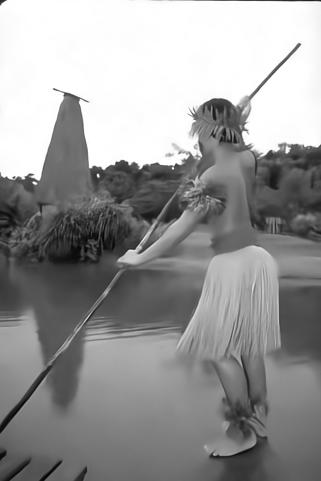
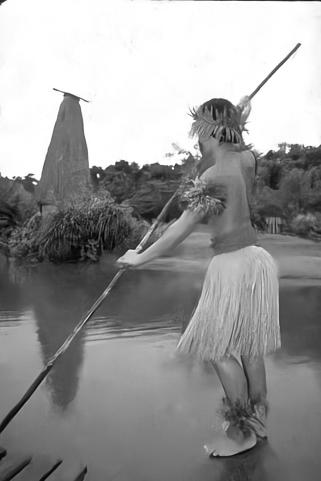
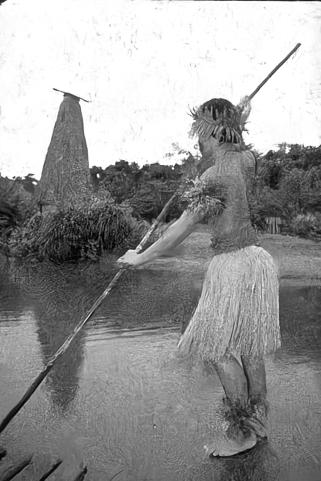
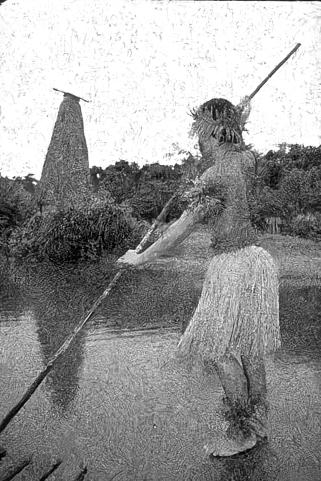
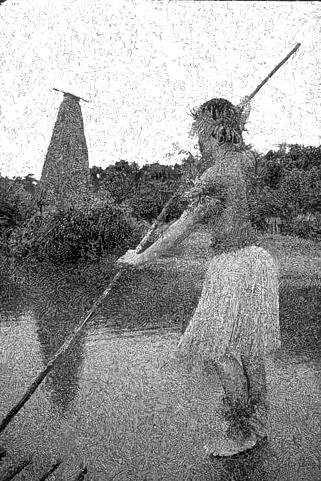
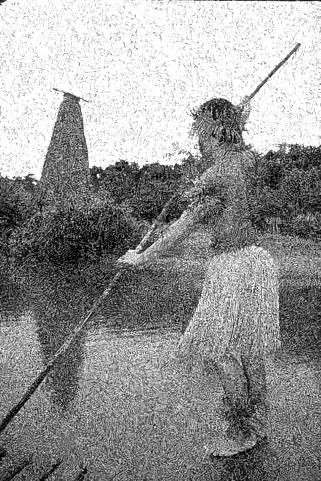
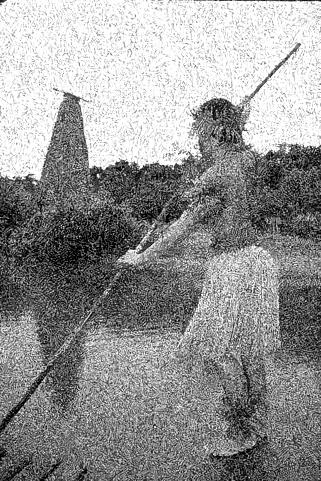
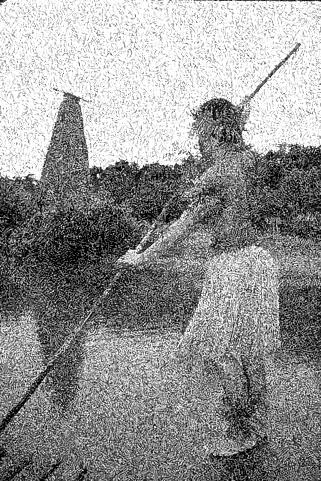
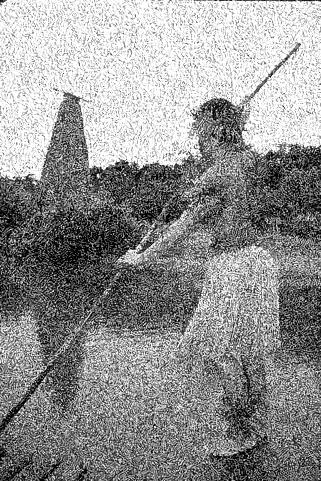
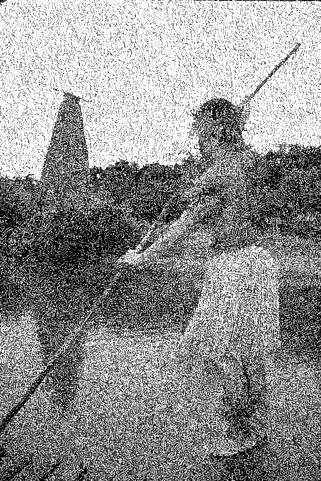
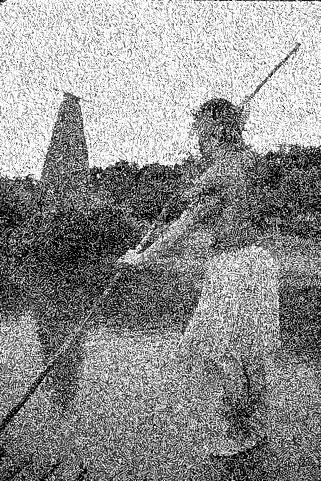


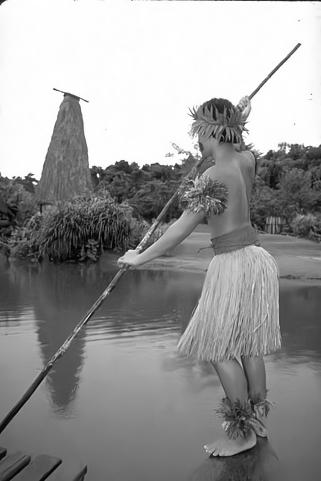
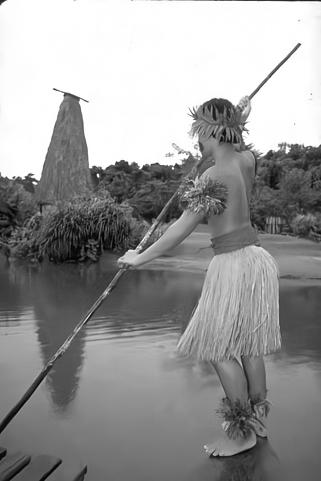
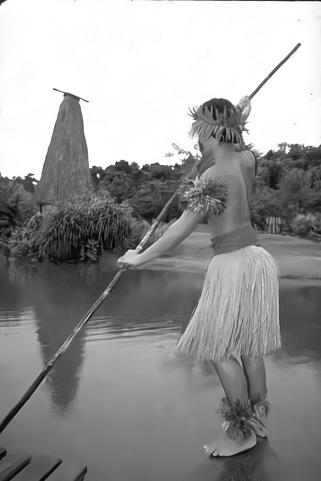
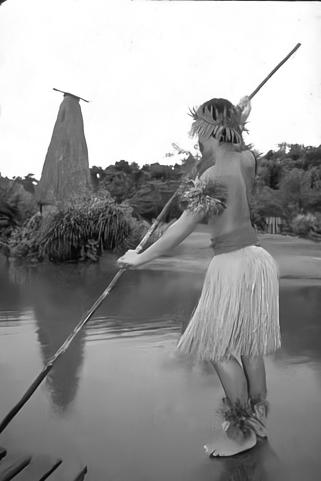
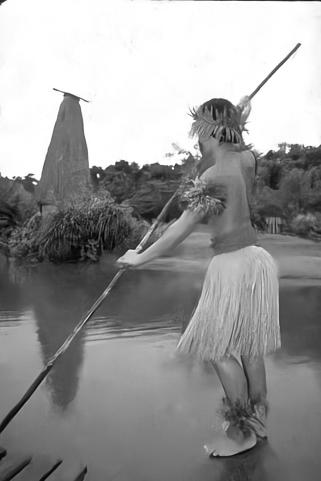
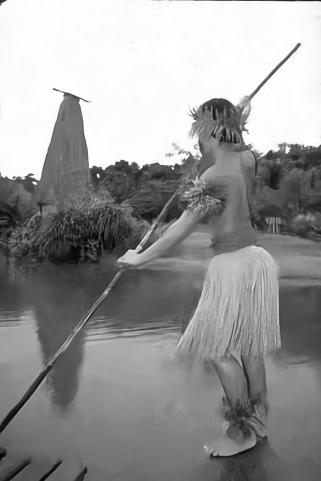
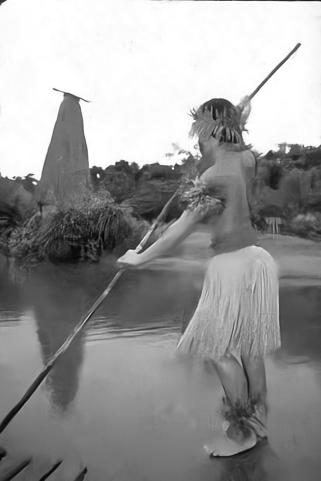
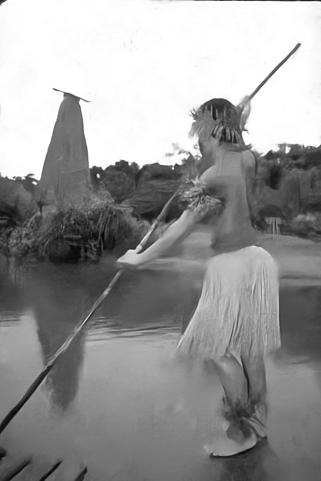
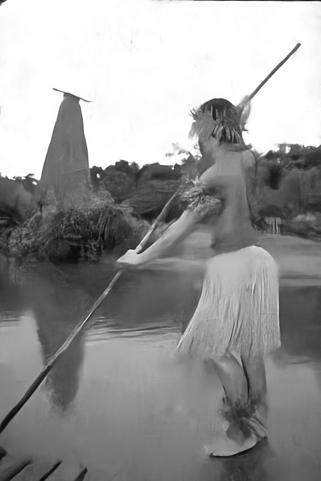
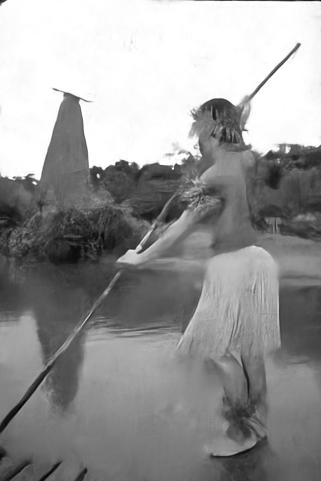
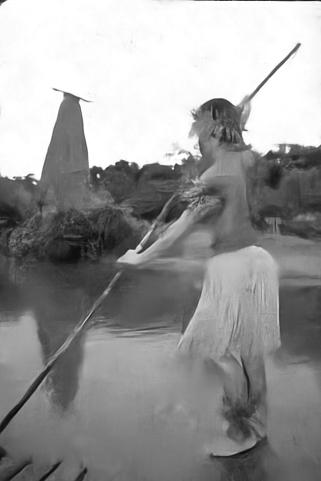
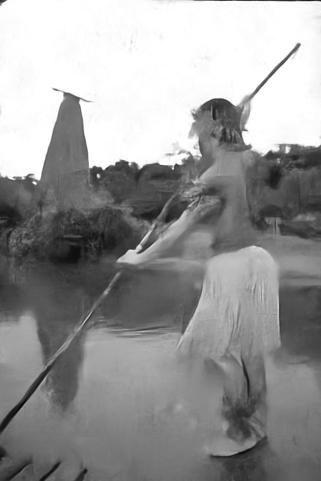
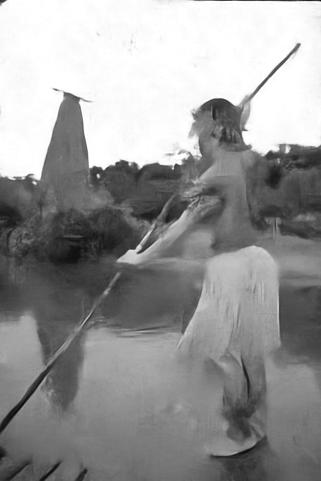
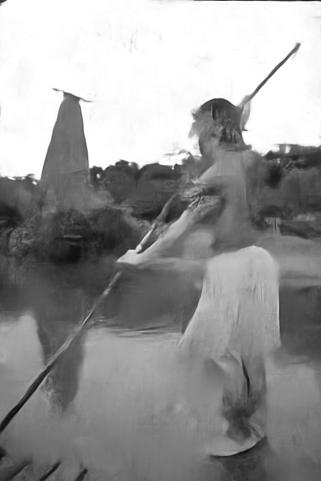

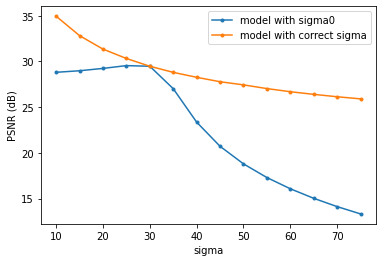

In [6]:
from models import DnCNN, DnCNN_pretrained
from denoising_helpers import test_denoiser, PSNR
from vistools import unzip

# load an image (change the number to test other images)
image = io.imread('datasets/BSD68/test002.png').astype(np.float32)

# set a noise level
sigma0 = 30

im_clean = image.astype('float32')
noise = np.random.normal(0, 1., im_clean.shape)

# load pre-trained DnCNN
dncnn_sigma0 = DnCNN_pretrained(sigma0)

sigmas = np.linspace(10,75,14)   #sigmas = np.linspace(5,80,76)
#print(sigmas)

PSNR_dncnn_sigma0 = list()
PSNR_dncnn_sigma  = list()
# outputs list of pairs (image, text)
outputs = list()

# apply them to the image
for i, sigma in enumerate(sigmas):
    print('%d '%i, end='')
    
    # add noise
    im_noisy = im_clean + sigma * noise

    # load correct model
    dncnn_sigma = DnCNN_pretrained(sigma)
    
    # denoise image with both models
    out_sigma0 = test_denoiser(dncnn_sigma0, im_noisy, None, has_noise=True)[0]
    out_sigma  = test_denoiser(dncnn_sigma , im_noisy, None, has_noise=True)[0] 
    
    PSNR_dncnn_sigma0.append( PSNR(out_sigma0, im_clean) )
    PSNR_dncnn_sigma.append(  PSNR(out_sigma , im_clean) )
    
    outputs.append( (out_sigma0, 'noise sigma = %f - model sigma = %f - PSNR = %f' %(sigma, sigma0, PSNR_dncnn_sigma0[i])) )    
    outputs.append( (out_sigma,  'noise sigma = %f - model sigma = %f - PSNR = %f' %(sigma, sigma,  PSNR_dncnn_sigma[i])) ) 
    
# show as a gallery
if len(outputs)/2 < 20:
    vistools.display_gallery(unzip(outputs[::2],0),unzip(outputs[::2],1))
    vistools.display_gallery(unzip(outputs[1::2],0),unzip(outputs[1::2],1))


plt.plot(sigmas, PSNR_dncnn_sigma0, '.-', label='model with sigma0')
plt.plot(sigmas, PSNR_dncnn_sigma , '.-', label='model with correct sigma')
plt.legend(); plt.xlabel('sigma'); plt.ylabel('PSNR (dB)');

This result is reasonable. Note that the denoised images obtained with a fixed $\sigma_0$ are oversmoothed when $\sigma < \sigma_0$ and increasingly noisy for $\sigma > \sigma_0$. In both cases the PSNR is below the one obtained for the correct $\sigma$.

## Stress tests on DnCNN: shifting the input

In this experiment we study the performance of the DnCNN network as the intensity range of the input image $u$ is shifted. 

For that we will take an image $u$ and first reduce its initial intensity range [0,255] by a constant factor of 5 in order to obtain an image with values in the range [0, 51]. Then we will shift this image by a constant $b$: 
$$\widetilde u = u/5 + b.$$ 
If $b\in [0,200]$, then $\widetilde u$ is in the range [0,255].  For this experiment we will fix $\sigma_0=10$. 

<font color='blue'>**Question 1.** <!-- Use the code of the previous block as inspiration for--> The following code creates a plot of the PSNR as a function of $b$ for values of $b \in [-50,230]$ (`bs = np.linspace(50,230,14)`). 
1. What do you observe about the denoiser performance for different values of $b$? 
2. Can you explain the result?
</font>



<font color=red>**ANSWER TO QUESTION 1**</font>

1. For the majority of the values of b (between 0 and 200), the PSNR doesn't change very much and the results also look really similar. However for extreme values (lowest and highest) there is a clear degradation of the results, both noticable in terms of the PSNR and visually.

2. When b falls outside the range [0,200], the shifted image also falls out of the range [0,255]. The network was trained on grayscale images, where all the pixels are in the range [0,255]. Since this kind of image (with values outside the "natural" range), was never shown to the network during training, is expected that the results weren't good. The weights (specially the biases) of the network weren't adapted to handle inputs in this range, that's why the network "explodes". On a side matter, note that when we're dividing the input, as well as dividing the signal we're dividing the noise, so the actual $\sigma$ is smaller than $\sigma_0$. Based on the results of the previous experiment, we've seen that although the performance degrades in this situation, the results are still somehow acceptable (the converse is not true, when the testing noise was greater than the training noise, the results were far worse).

0 1 2 3 4 5 6 7 8 9 10 11 12 13 


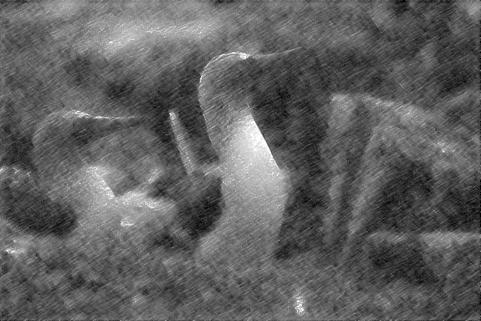
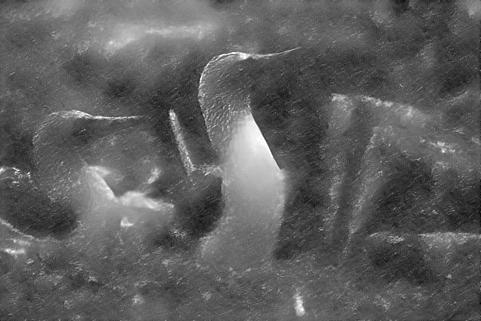
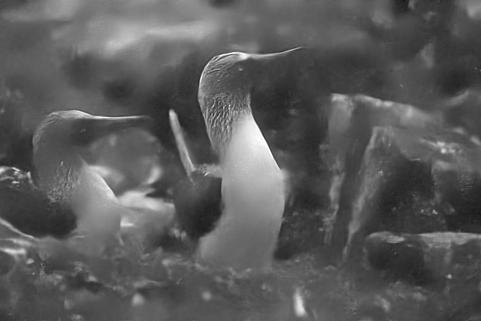
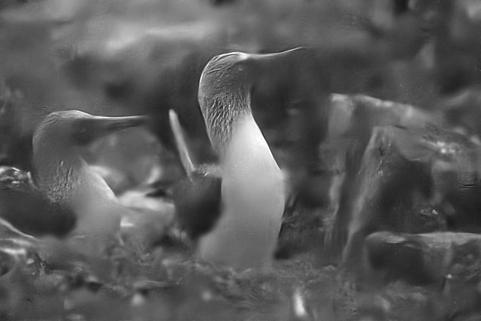
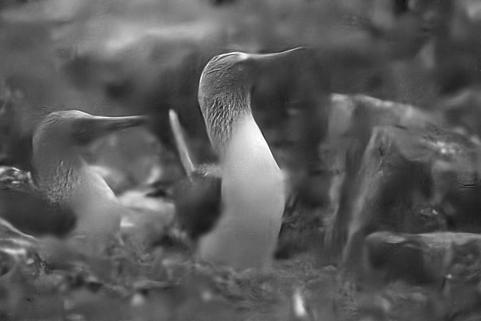
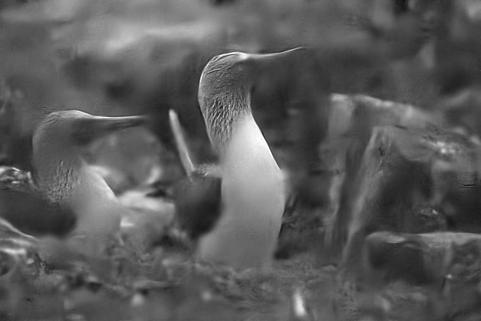
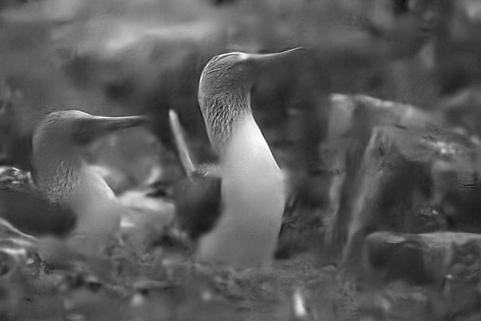
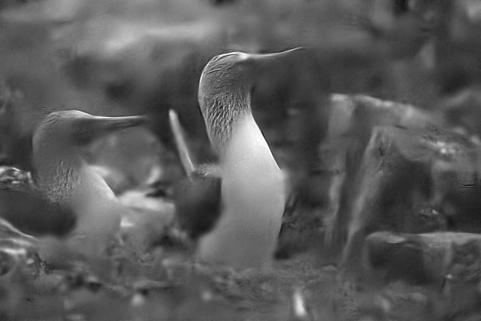
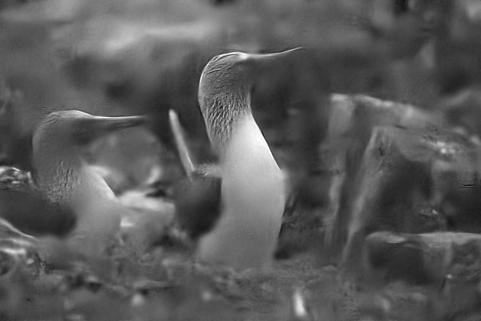
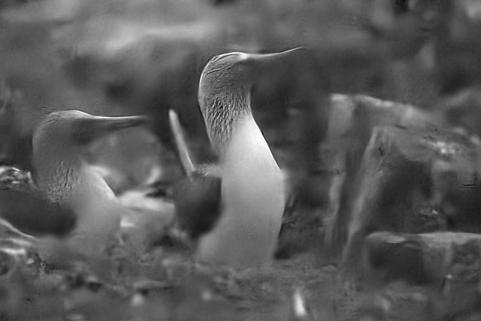
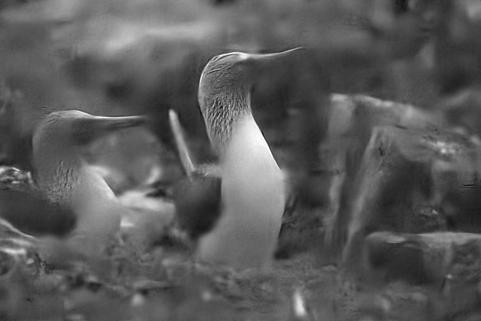
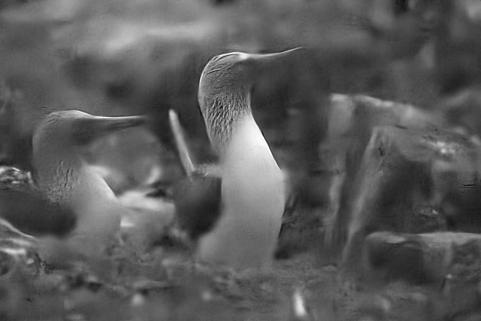
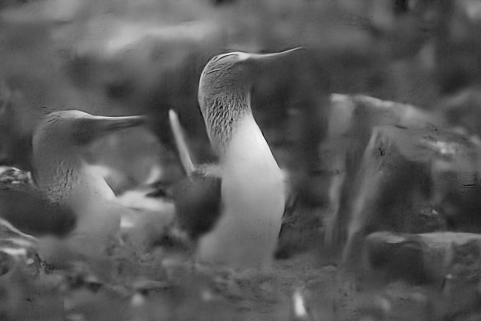
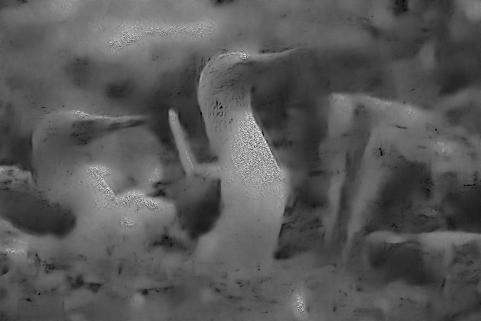

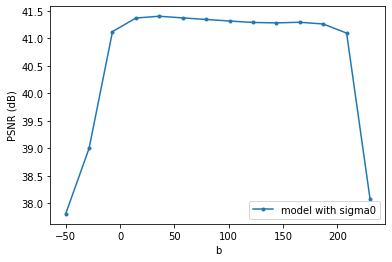

In [7]:
from models import DnCNN, DnCNN_pretrained
from denoising_helpers import *
from vistools import unzip

# load an image (change the number to test other images)
image = io.imread('datasets/BSD68/test004.png').astype(np.float32)

# set a noise level
sigma0 = 10
noise = np.random.normal(0., 1., image.shape)
scale = 5

# load pre-trained DnCNN
dncnn_sigma0 = DnCNN_pretrained(sigma0)

bs = np.linspace(-50,230,14)

PSNR_dncnn_sigma_shift = list() 
# outputs list of pairs (image, text)
outputs = list()

# apply them to the image
for i, b in enumerate(bs):
    print('%d '%i, end='')

    # scale clean image and add noise
    im_clean = image/scale + b
    im_noisy = im_clean + sigma0 * noise
    # denoise image and compute PSNR
    out_sigma0 = test_denoiser(dncnn_sigma0, im_noisy, None, has_noise=True)[0]
    PSNR_dncnn_sigma_shift.append( PSNR(out_sigma0, im_clean) )
    outputs.append( ( (out_sigma0-b)*scale , 'b = %f - sigma = %f - PSNR = %f' % (b, sigma0, PSNR_dncnn_sigma_shift[i])) )


######
###### NOTE THAT in the gallery the images are scaled back to the range [0,255]   
######

# show as a gallery
if len(outputs) < 80:
    vistools.display_gallery( unzip(outputs,0), unzip(outputs,1) )

plt.plot(bs, PSNR_dncnn_sigma_shift, '.-', label='model with sigma0')
plt.legend(); plt.xlabel('b'); plt.ylabel('PSNR (dB)');

# Stress tests on DnCNN: affine scalings

Now suppose we only have a pre-trained network for a noise level $\sigma_0$. We would like to denoise an image $u$ contaminated with $\sigma$. We can apply an affine scale change to our image so that the standard deviation of the noise becomes $\sigma_0$:
$$u_s = \frac{\sigma_0}{\sigma}(u - \overline{u}) + \overline{u} = \frac{\sigma_0}{\sigma}u + \overline{u}\left(1 - \frac{\sigma_0}{\sigma}\right) = \alpha u + \beta,$$
where $\overline u$ is the average gray level of $u$. The constant $\beta$ was added so that $\overline u_s = \overline u$. The idea is then to apply the denoising network to $u_s$ and then invert the affine transformation:

$$\hat u = \frac1\alpha \mathcal{F}_{\sigma_0}(\alpha u + \beta) - \frac\beta\alpha.$$


In the following experiment we will study how the results of the network vary with $\sigma$.


<br/>
<br/>

**Attention:** For performance reasons, the variables `PSNR_dncnn_sigma0` and `PSNR_dncnn_sigma` of this block are re-used from the block "*Stress tests on DnCNN: robustness to changes in $\sigma$*", that was executed before.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 


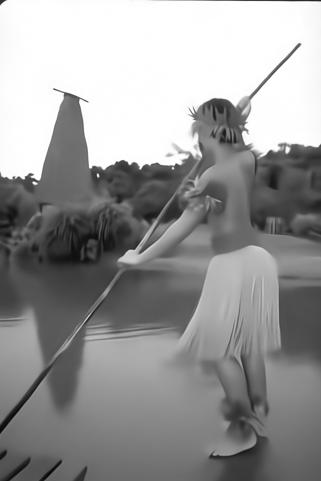
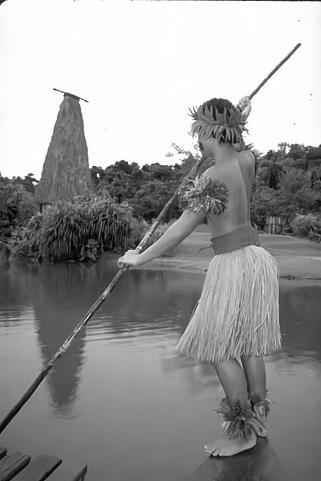
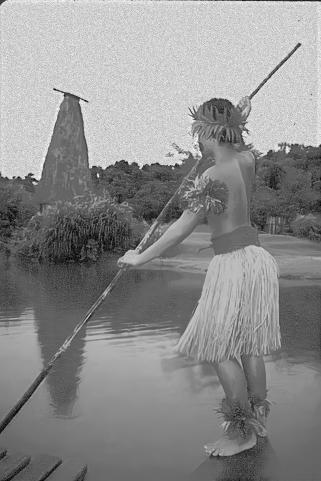
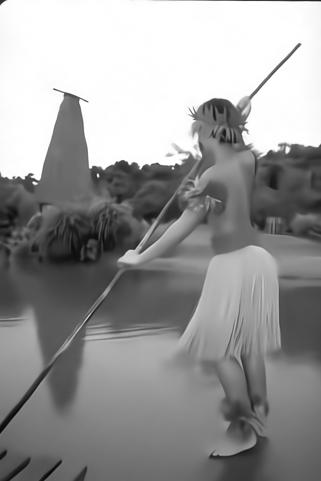
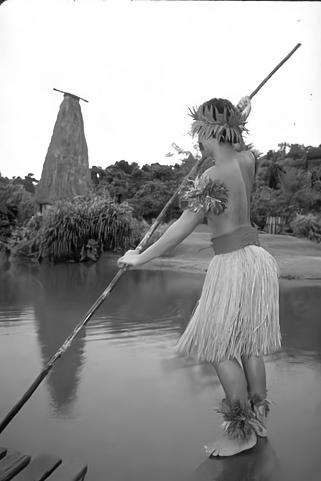
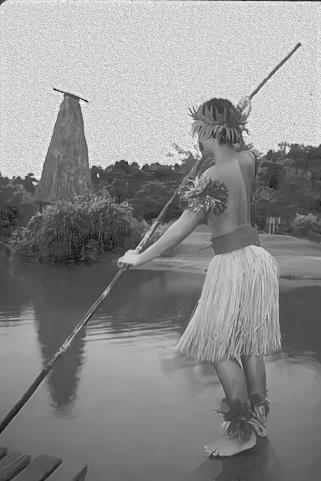
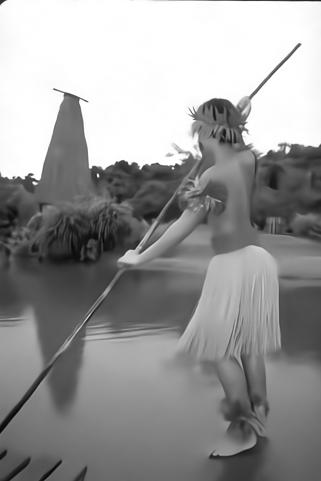
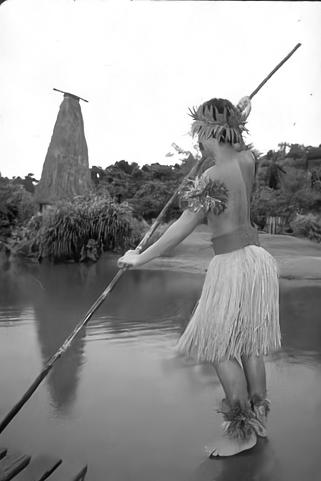
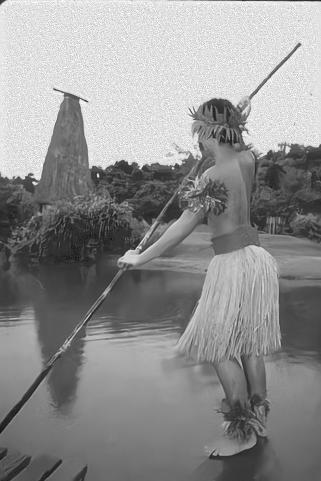
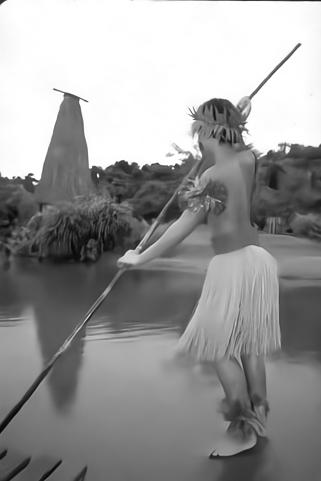
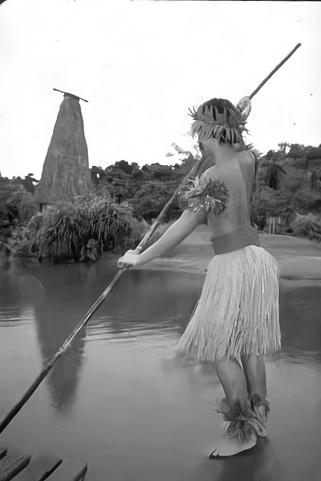
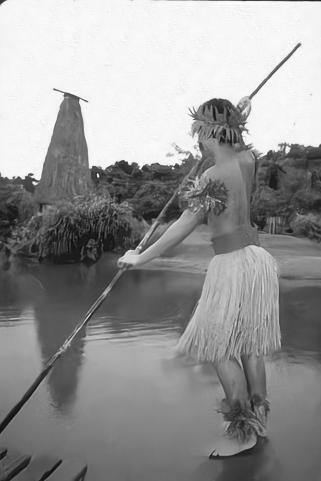
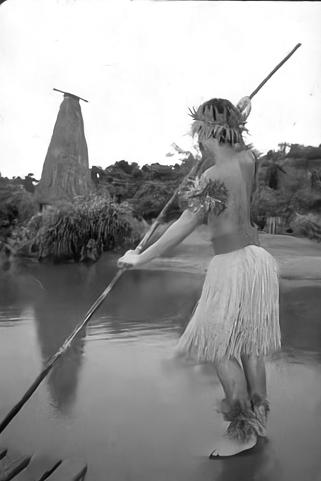
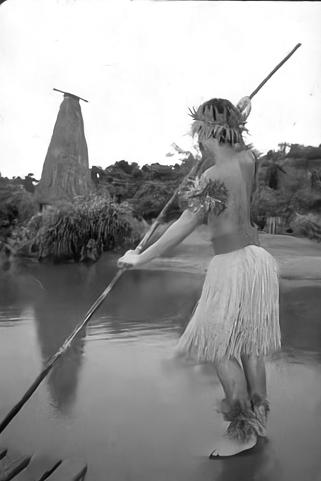
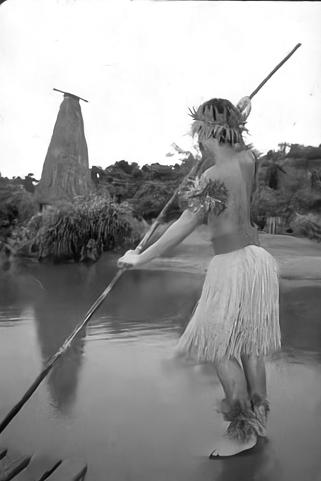
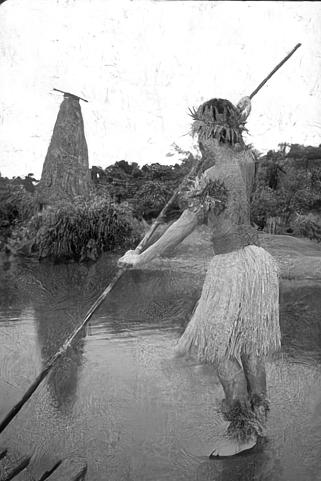
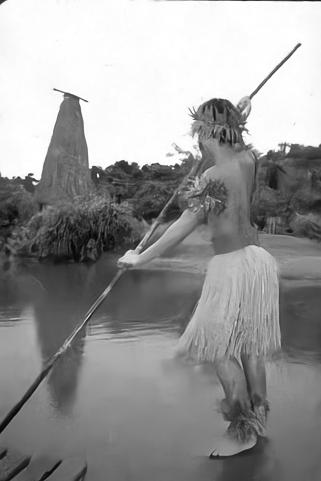
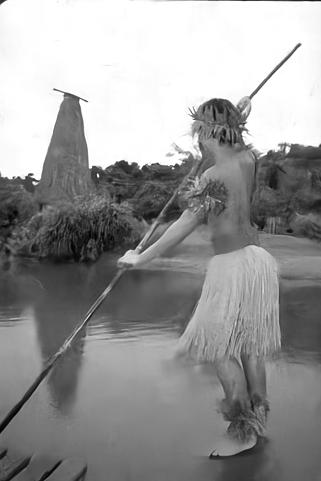
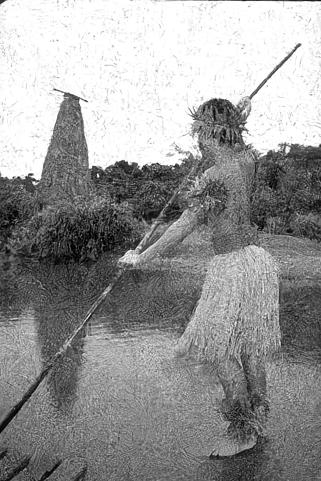
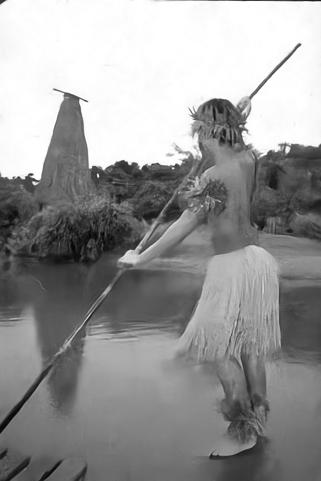
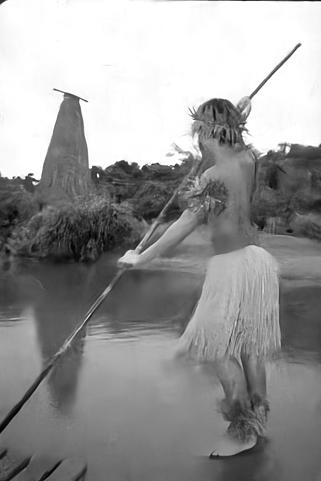
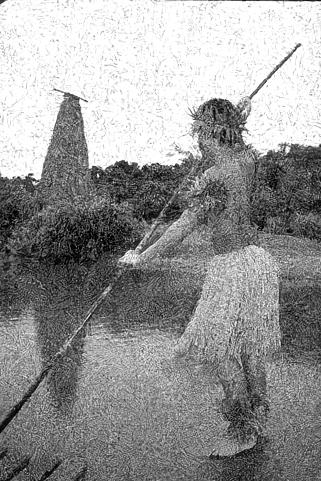
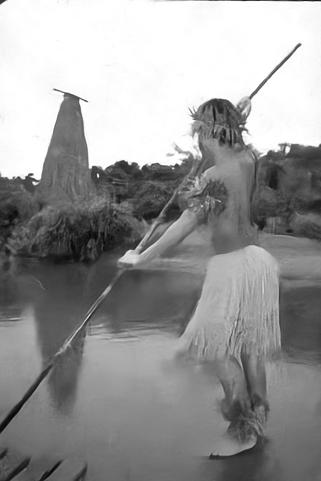
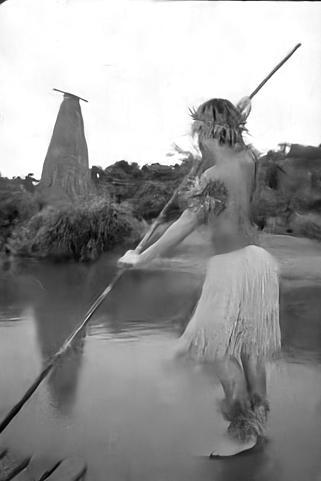
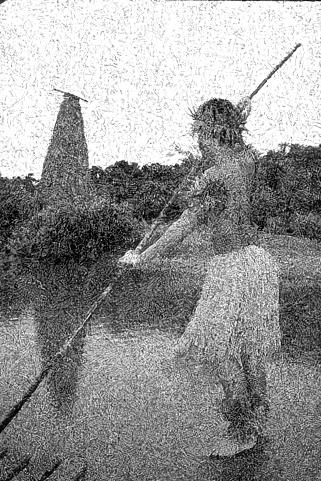
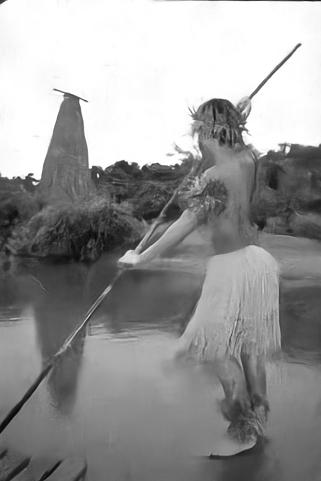
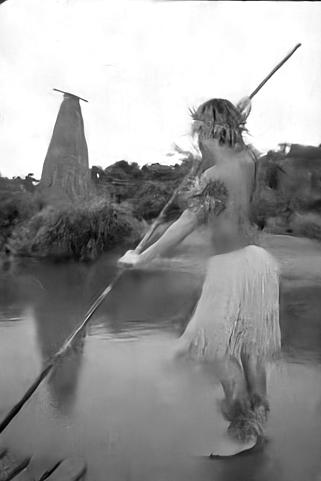
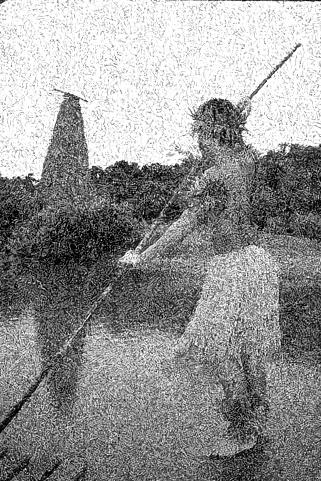
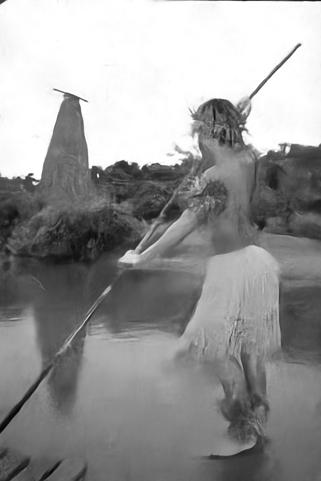
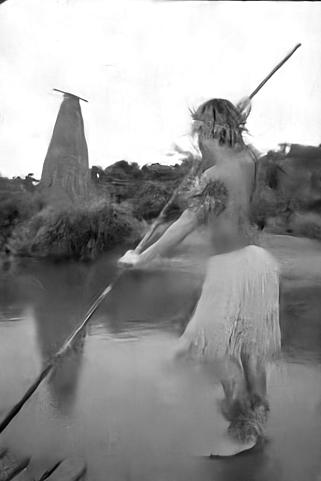
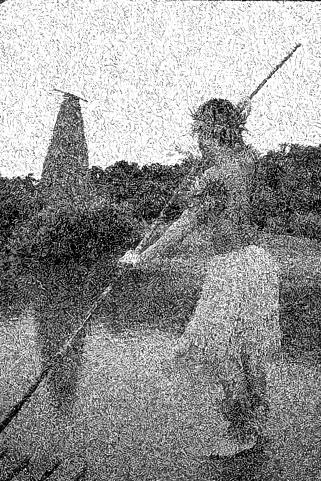
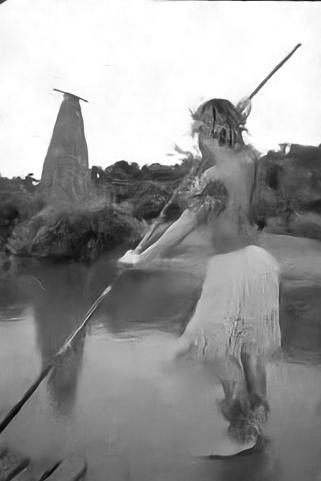
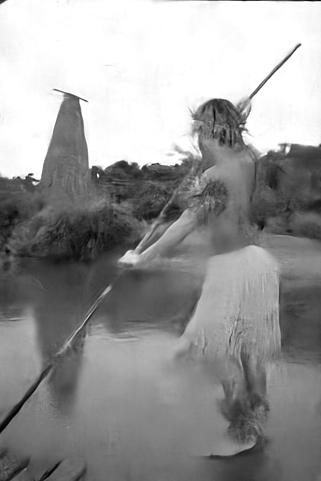
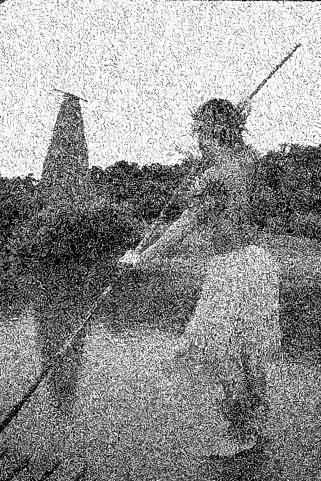
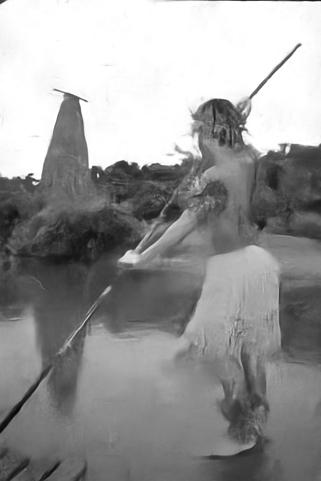
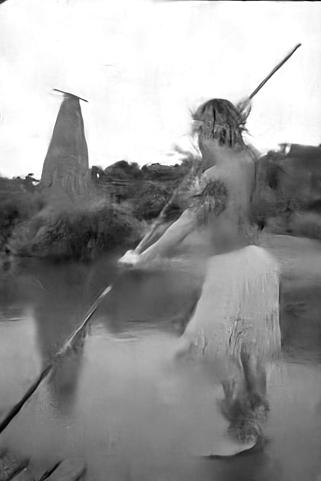
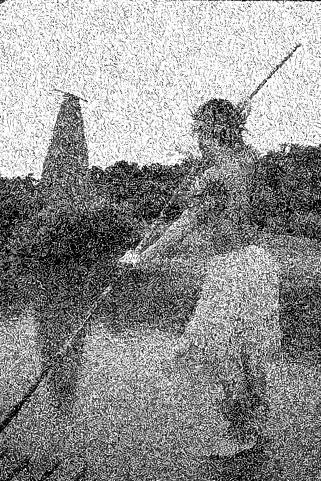
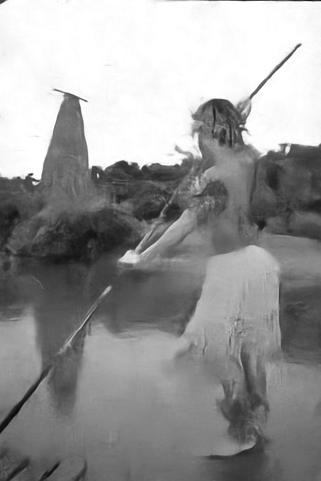
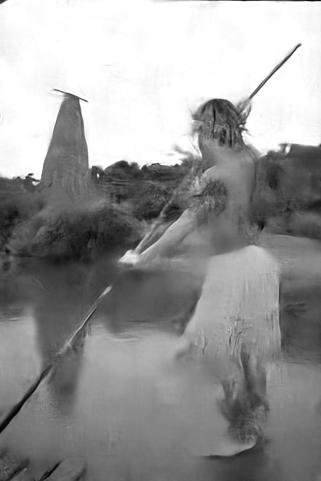
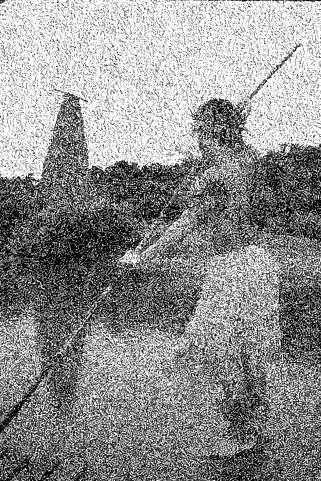
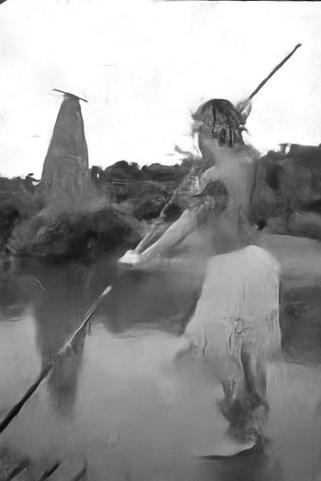
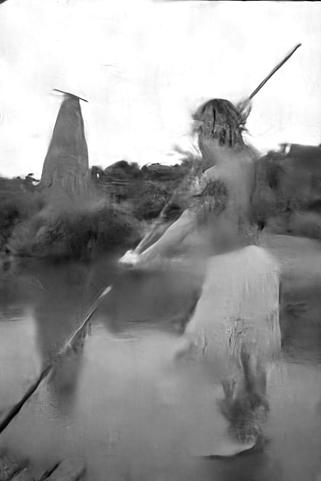

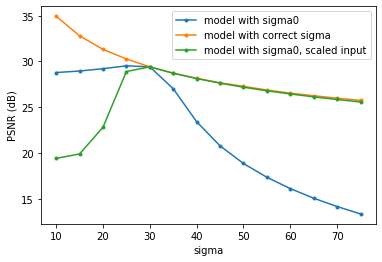

In [8]:
from models import DnCNN, DnCNN_pretrained
from denoising_helpers import *
from vistools import unzip

# load an image (change the number to test other images)
image = io.imread('datasets/BSD68/test002.png').astype(np.float32)

# set a noise level
sigma0 = 30

im_clean = image.astype('float32')
noise = np.random.normal(0, 1., im_clean.shape)

# load pre-trained DnCNN
dncnn_sigma0 = DnCNN_pretrained(sigma0)

sigmas = np.linspace(10,75,14)  #sigmas = np.linspace(5,80,76)
#print(sigmas)

##############
### THE PSNR_dncnn_sigma0 and PSNR_dncnn_sigma VARIABLES ARE COMPUTED IN SECTION: 
###    Stress tests on DnCNN: robustness to changes in $\sigma$ 
##############

PSNR_dncnn_sigma0 = list()
PSNR_dncnn_sigma  = list()
PSNR_dncnn_scaled = list() 

outputs = list()

# apply them to the image
for i, sigma in enumerate(sigmas):
    print('%d '%i, end='')
    
    # add noise
    im_noisy = im_clean + sigma * noise

    # load correct model
    dncnn_sigma = DnCNN_pretrained(sigma)
    
    # denoise image with both models
    out_sigma0 = test_denoiser(dncnn_sigma0, im_noisy, None, has_noise=True)[0]
    out_sigma  = test_denoiser(dncnn_sigma , im_noisy, None, has_noise=True)[0]
    
    # scaling to match model noise level
    a = sigma0/sigma
    b = np.mean(im_noisy)*(1-a)
    out_scaled = test_denoiser(dncnn_sigma0, a*im_noisy + b, None, has_noise=True)[0]
    out_scaled = 1/a*out_scaled - b/a
    
    PSNR_dncnn_sigma0.append(PSNR(out_sigma0, im_clean))
    PSNR_dncnn_sigma .append(PSNR(out_sigma , im_clean))
    PSNR_dncnn_scaled.append(PSNR(out_scaled, im_clean))

    outputs.append( (out_sigma0, 'noise sigma = %f - model sigma = %f - PSNR = %f' % (sigma, sigma0, PSNR_dncnn_sigma0[i])) )
    outputs.append( (out_sigma,  'noise sigma = %f - model sigma = %f - PSNR = %f' % (sigma, sigma , PSNR_dncnn_sigma [i])) )
    outputs.append( (out_scaled, 'noise sigma = %f - scaled to sigma %f - PSNR = %f' % (sigma, sigma0, PSNR_dncnn_scaled[i])) )
    
    
# show as a gallery
if len(outputs) < 80:
    vistools.display_gallery( unzip(outputs,0), unzip(outputs,1) )

plt.plot(sigmas, PSNR_dncnn_sigma0, '.-', label='model with sigma0')
plt.plot(sigmas, PSNR_dncnn_sigma , '.-', label='model with correct sigma')
plt.plot(sigmas, PSNR_dncnn_scaled, '.-', label='model with sigma0, scaled input')
plt.legend(); plt.xlabel('sigma'); plt.ylabel('PSNR (dB)');

Let's compute the $\Delta PSNR$ between the *scaled input* and *correct sigma* outputs.

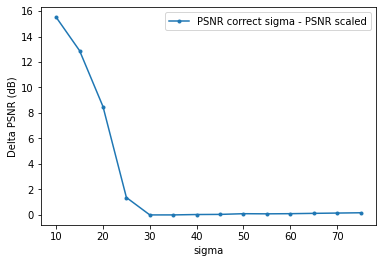

In [9]:
deltaPSNR = np.array(PSNR_dncnn_sigma) - np.array(PSNR_dncnn_scaled)

plt.plot(sigmas, deltaPSNR, '.-', label = 'PSNR correct sigma - PSNR scaled')
plt.legend(); plt.xlabel('sigma'); plt.ylabel('Delta PSNR (dB)');

<font color='blue'>**Question 2.** 
1. Can you explain the behavior of the method with scaled input for $\sigma\geq 30$? 
2. What about $\sigma<30$? 
3. Do  you see a way to obtain a method with good performance over a wider range of sigma values? </font>

<font color='red'>**ANSWER TO QUESTION 2**</font>

All the discussion limits to checking if the input to the network is stil on the range [0,255] or not. When $\sigma_0 \leq \sigma$ the scaled input is on the range, on the other hand, when $\sigma_0 \geq \sigma$ the scalling "expands" the range of the image and causes part of it to fall outside the range [0,255].

1. The results are good. The noise of the image is "adapted" to the noise expected by the network, and the image has "valid" values, so the network is able to denoise the image.

2. The results are bad, in fact, they're worse than without scaling the input. This is explained by the same effect we saw in the previous experiment. The input image expands outside the range [0,255], so the network doesn't work.

3. I'd consider a method homogeneus to scaling the inputs, i.e $F(x) = \frac{F(\alpha x)}{\alpha}$. In that case, one doesn't need to scale the input, so the model can be used even with noise levels that are smaller than the one using during training (up to some extent, as it will be discussed in the next parts). Other viable option is to include data augmentation during training so the network learns how to handle images outside the range [0,255].

# The case of DCT denoising

Let's consider the case of the DCT denoising. The DCT is a change of basis in the space of patches. The DCT basis is orthonormal, and let us denote it by $\mathcal B = \{b_1, ..., b_d\}$, where $d$ is the dimension of the patches. We can express the DCT denoising of a patch as:
$$\text{DCT}_{\sigma_0}(P_x u) = \langle P_xu, b_1\rangle b_1 + \sum_{i=2}^d S\left(\langle P_xu,b_i\rangle,\sigma_0\right) b_i,$$
where $S$ is a shrinkage operator of parameter $\sigma_0$. For example, the hard-thresholding operator is given by
$$S_{\text{hard}}(x,\sigma_0) = 
\left\{
\begin{array}{l l}
x & \text{if } x \geq 3\sigma_0, \\
0 & \text{if } x  < 3\sigma_0.
\end{array}\right.$$

Suppose we want to denoise an image corrupted with noise $\sigma$, but instead of using the DCT denoiser with parameters corresponding to $\sigma_0$, we can only use the DCT denoiser for $\sigma_0$.

<font color='blue'>**Question 3.** 
1. Show that 
$$\text{DCT}_{\sigma_0/\alpha}(P_x u) = \text{DCT}_{\sigma_0}(\alpha P_x u)\,/\,\alpha$$
2. and that 
$$\text{DCT}_{\sigma_0}(P_x u) + \beta \mathbf{1} = DCT_{\sigma_0}(P_xu + \beta\mathbf 1),$$

where $\alpha,\beta\in \mathbb R$ and $\mathbf 1 = (1,1,...,1)^T\in \mathbb R^d$ refers to a constant patch of ones. 
</font>
<!--Use this property to denoise an image with noise $\sigma$ with $\text{DCT}_{\sigma_0}$.-->

<font color='red'>**ANSWER TO QUESTION 3**</font>

1. \begin{align}
\text{DCT}_{\sigma_0}(\alpha P_x u) &= \big<αP_x u, b_1 \big>b_1 + \sum_{i=2}^dS\big(\big<\alpha P_x u, b_i\big>, \sigma_0\big)b_i \\ &= \alpha \big<P_x u, b_1 \big>b_1 + \alpha \sum_{i=2}^d S\big(\big<P_x u, b_i\big>\,,\frac{\sigma_0}{\alpha}\big) \\ &= \alpha \text{DCT}_{\frac{\sigma_0}{\alpha}}(P_x u)
\end{align}

2. \begin{align}
\text{DCT}_{\sigma_0}\big(P_x u+ \beta \mathbb{1}\big) &= \big<P_x u + \beta \mathbb{1}, b_1\big>b_1 + \sum_{i=2}^dS\big(\big<P_x u + \beta \mathbb{1}, b_i\big>, \sigma_0\big)b_i \\ &= \big<P_x u, b_1 \big> b_1 + \big<\beta \mathbb{1}, b_1\big>b_1 + \sum_{i=2}^dS\big(<P_xu, b_i> + <\beta \mathbb{1}, b_i>, \sigma_0\big) b_i
\end{align}

  Note that $\beta\mathbb{1}$ being a constant, only projects to the first component of the DCT basis. I.e  $\beta \mathbb{1} = \big<\beta \mathbb{1}, b_1\big>b_1$

\begin{align}
\text{DCT}_{\sigma_0}\big(P_x u+ \beta \mathbb{1}\big) &= \big<P_x u, b_1\big>b_1 + \sum_{i=2}^dS\big(<P_xu, b_i>, \sigma_0\big)b_i + \beta \mathbb{1}
\end{align}

The following experiment uses this property to denoise an image with noise $\sigma$ with $\text{DCT}_{\sigma_0}$. 


0 1 2 3 4 5 6 7 8 9 10 11 12 13 


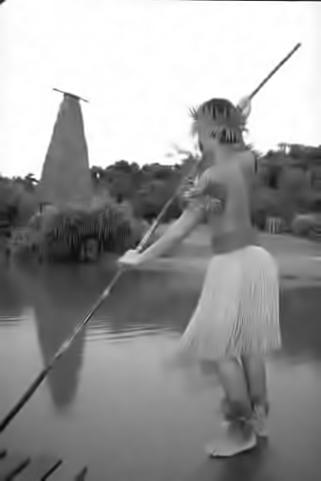
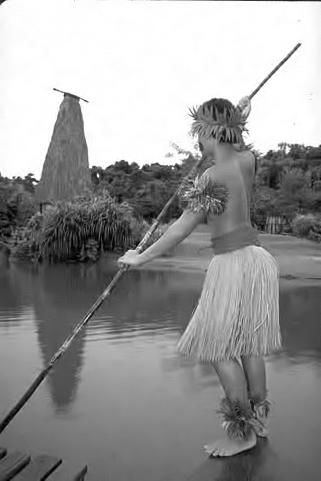
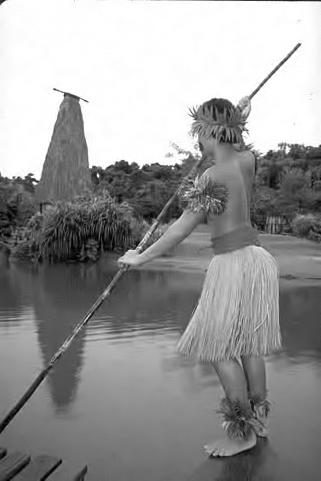
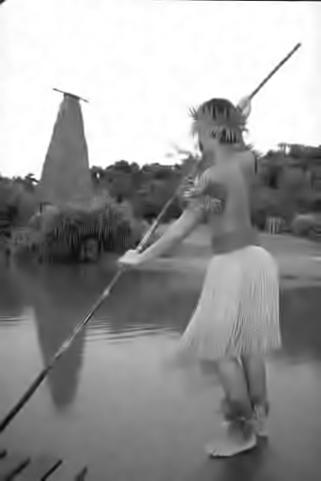
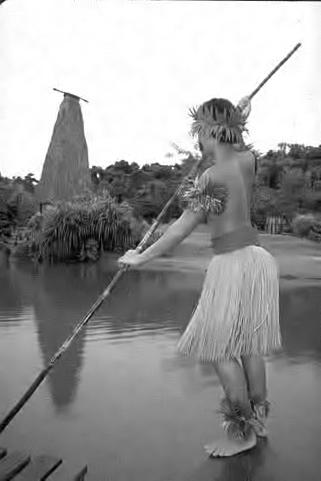
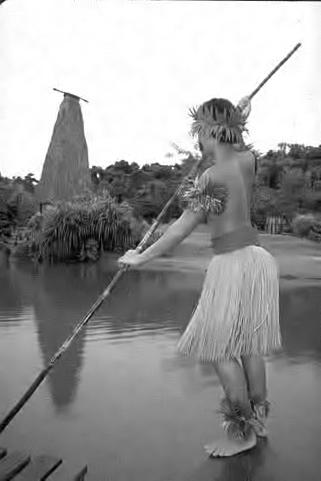
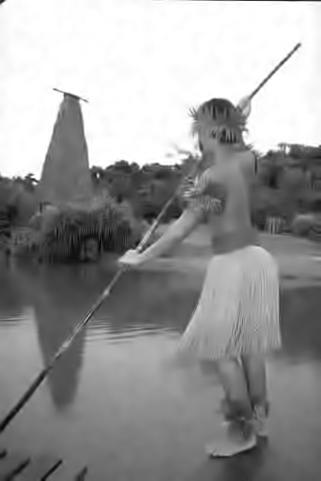
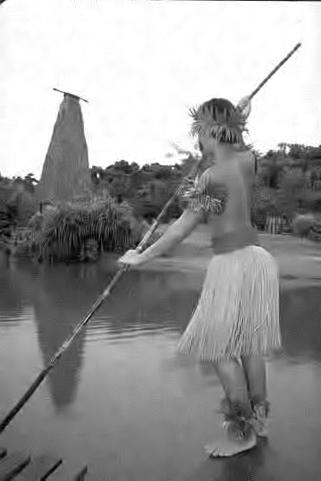
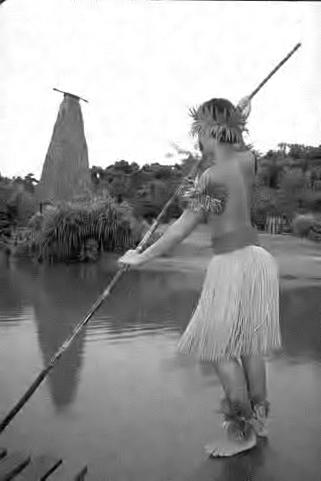
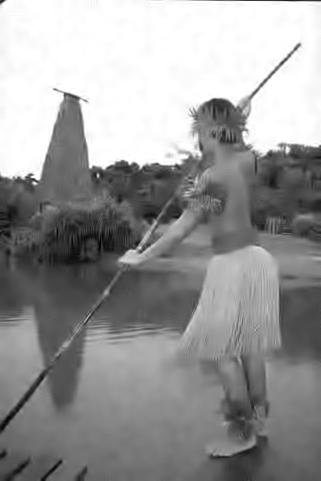
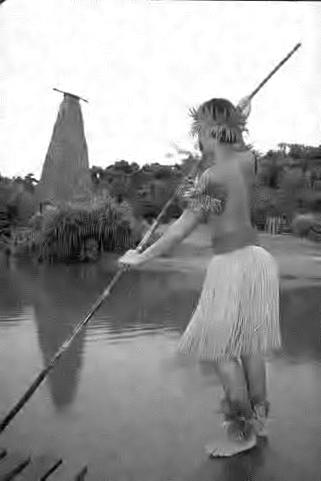
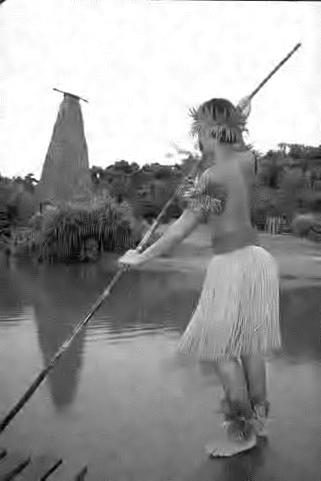
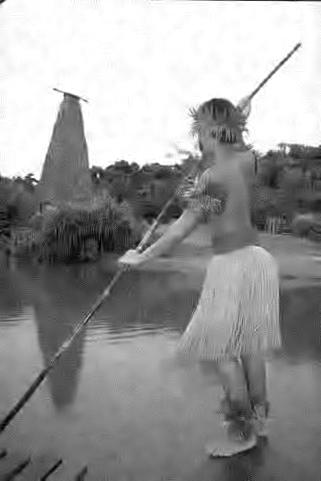
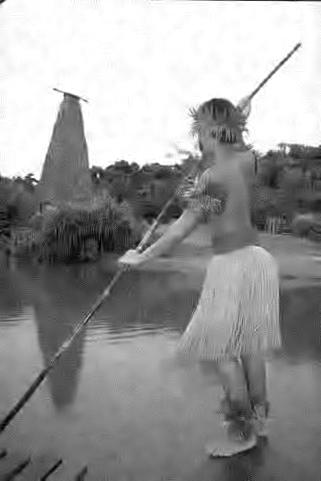
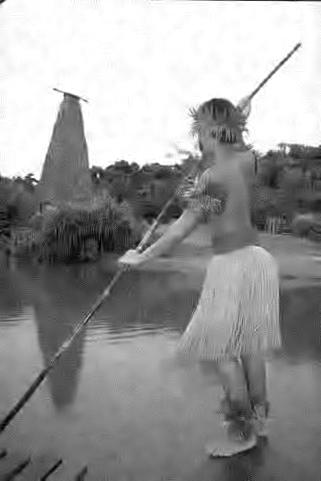
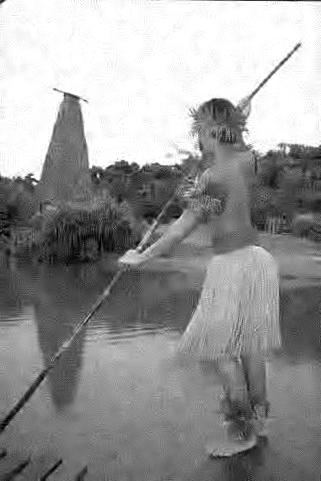
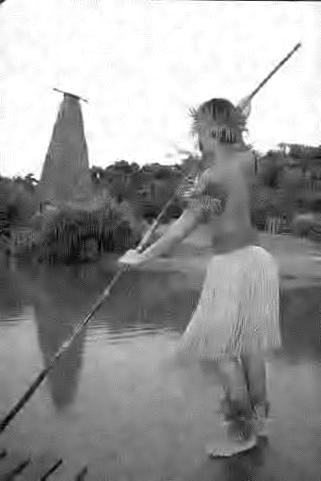
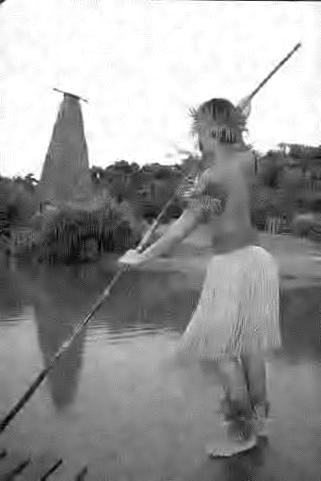
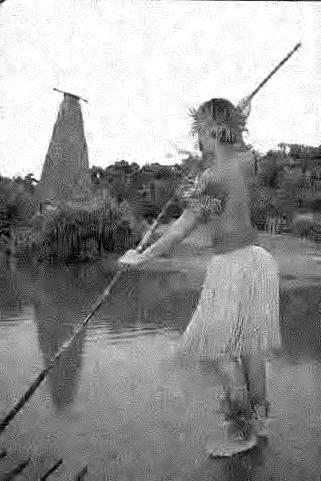
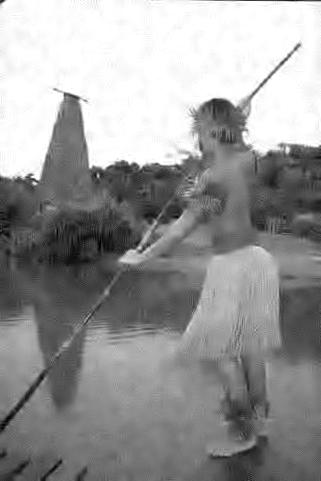
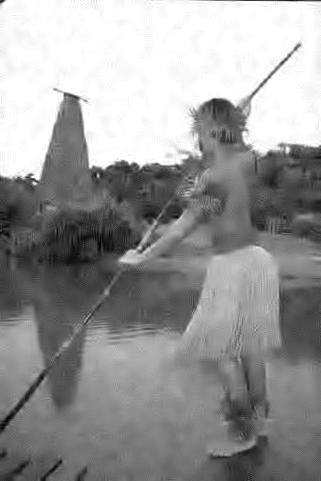
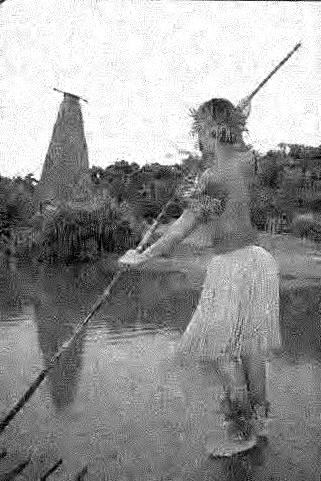
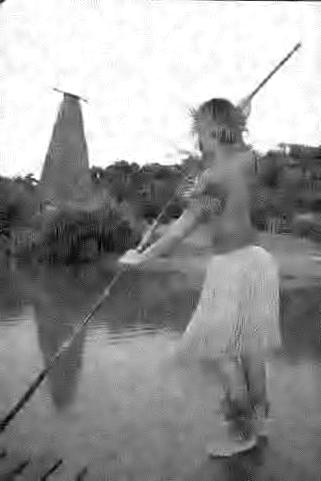
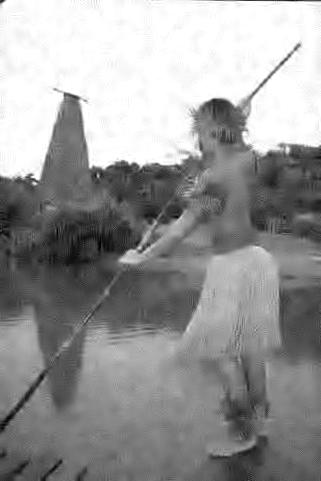
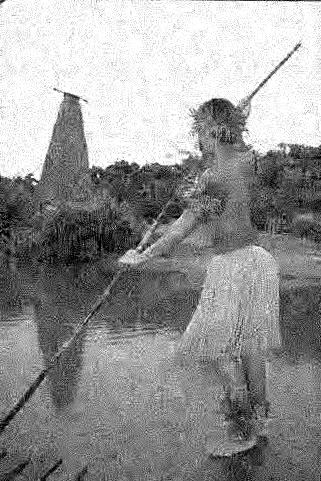
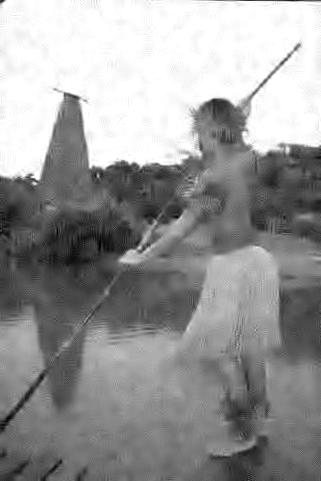
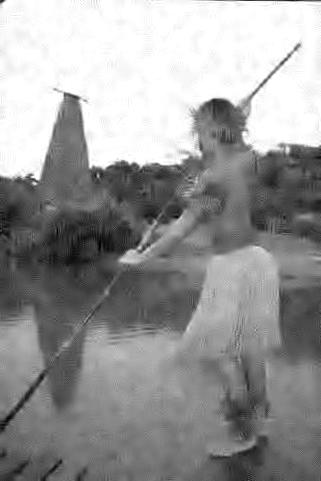
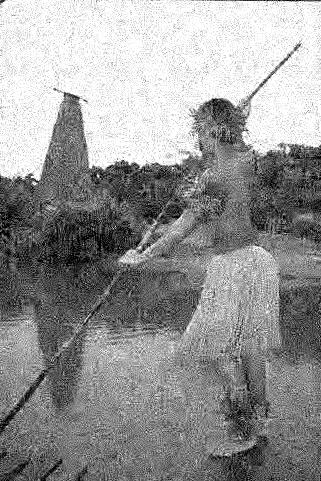
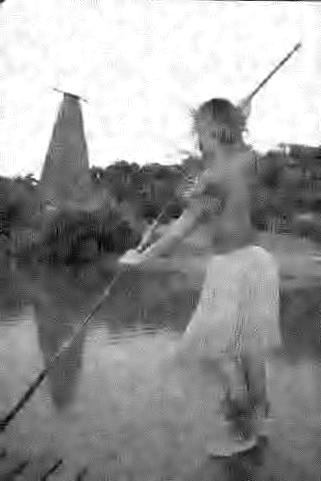
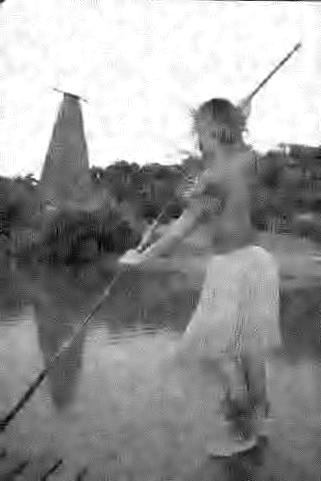
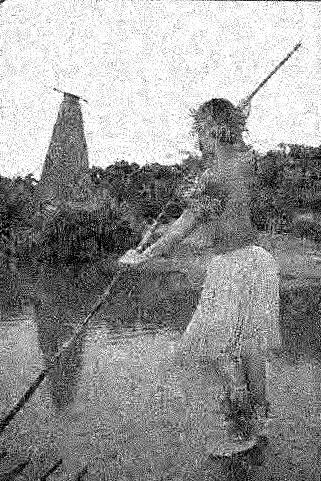
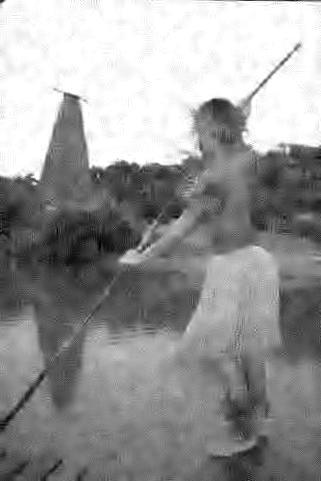
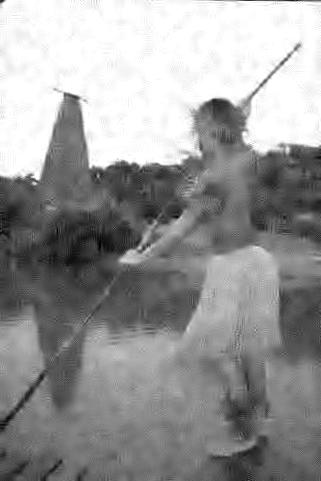
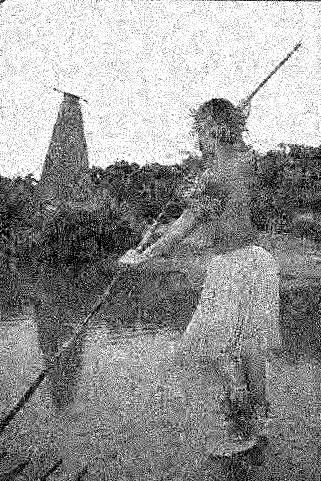
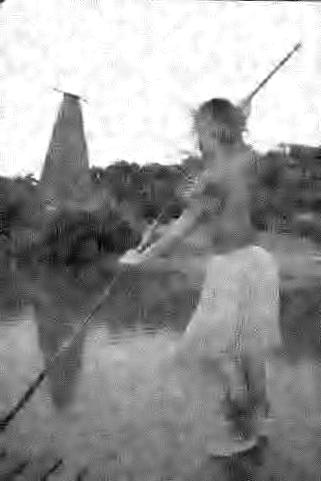
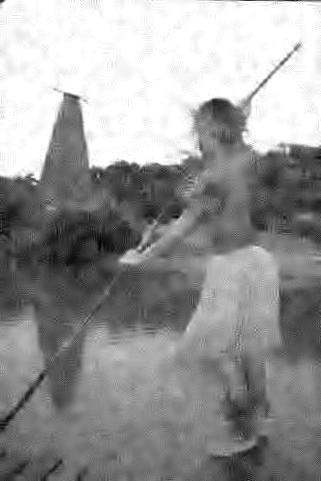
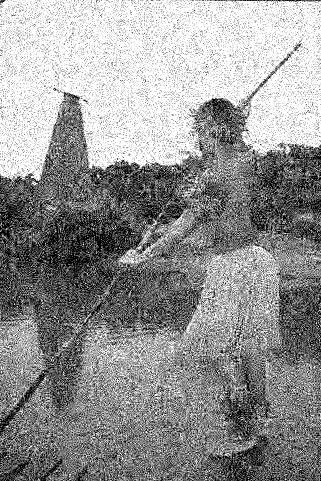
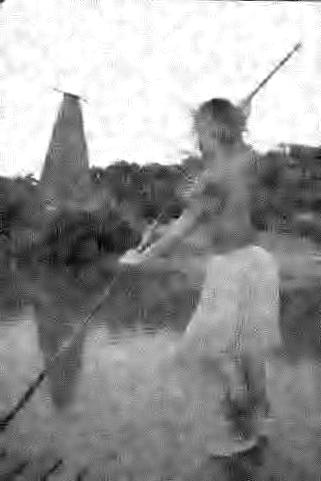
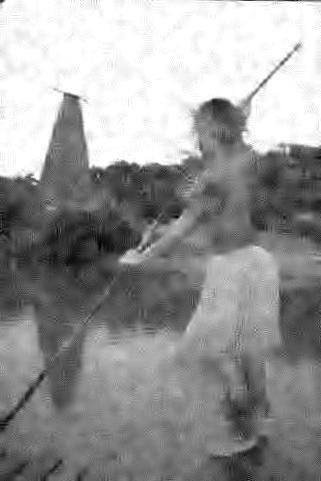
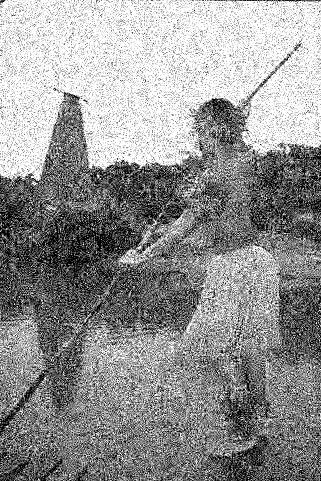
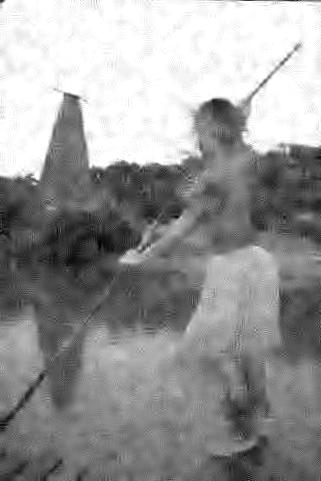
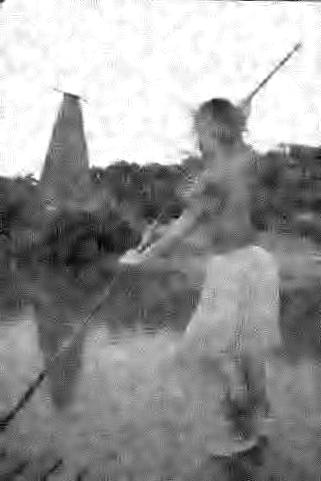

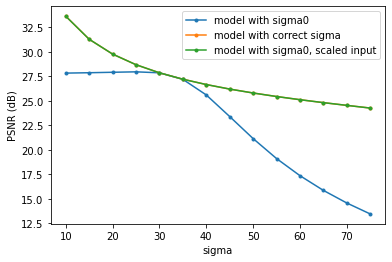

In [10]:
from models import DCTlike
from denoising_helpers import *
from vistools import unzip

# load an image (change the number to test other images)
image = io.imread('datasets/BSD68/test002.png').astype(np.float32)

# set a noise level
sigma0 = 30

im_clean = image.astype('float32')
noise = np.random.normal(0, 1., im_clean.shape)

# load pre-trained DnCNN
dct_sigma0 = DCTlike(8, sigma0, True)

sigmas = np.linspace(10,75,14) #sigmas = np.linspace(5,80,76)
#print(sigmas)

PSNR_sigma0 = np.zeros(len(sigmas))
PSNR_sigma  = np.zeros(len(sigmas))
PSNR_scaled = np.zeros(len(sigmas))

outputs = list()

# apply them to the image
for i, sigma in enumerate(sigmas):
    print('%d '%i, end='')
    
    # add noise
    im_noisy = im_clean + sigma * noise

    # load correct model
    dct_sigma = DCTlike(8, sigma, True)
    
    # denoise image with both models
    out_sigma0 = test_denoiser(dct_sigma0, im_noisy, None, has_noise=True)[0]
    out_sigma  = test_denoiser(dct_sigma , im_noisy, None, has_noise=True)[0]
    
    # scaling to match model noise level
    a = sigma0/sigma
    b = np.mean(im_noisy)*(1-a)
    out_scaled = test_denoiser(dct_sigma0, a*im_noisy + b, None, has_noise=True)[0]
    out_scaled = 1/a*out_scaled - b/a
    
    PSNR_sigma0[i] = PSNR(out_sigma0, im_clean)
    PSNR_sigma [i] = PSNR(out_sigma , im_clean)
    PSNR_scaled[i] = PSNR(out_scaled, im_clean)

    outputs.append( (out_sigma0,'noise sigma = %f - model sigma = %f - PSNR = %f' % (sigma, sigma0, PSNR_sigma0[i])) )
    outputs.append( (out_sigma ,'noise sigma = %f - model sigma = %f - PSNR = %f' % (sigma, sigma , PSNR_sigma [i])) )
    outputs.append( (out_scaled,'noise sigma = %f - scaled to sigma %f - PSNR = %f' % (sigma, sigma , PSNR_scaled[i])) )
    
    
# show as a gallery
if len(outputs) < 80:
    vistools.display_gallery( unzip(outputs,0), unzip(outputs,1) )

plt.plot(sigmas, PSNR_sigma0, '.-', label='model with sigma0')
plt.plot(sigmas, PSNR_sigma , '.-', label='model with correct sigma')
plt.plot(sigmas, PSNR_scaled, '.-', label='model with sigma0, scaled input')
plt.legend(); plt.xlabel('sigma'); plt.ylabel('PSNR (dB)');

# FFDNet

We will now study FFDNet, which was proposed as an improvement to DnCNN by the same group:

*Zhang, K., Zuo, W. and Zhang, L., 2018. FFDNet: Toward a fast and flexible solution for CNN-based image denoising.
IEEE Transactions on Image Processing, 27(9), pp.4608-4622.*

<img width=700 src="https://raw.githubusercontent.com/gfacciol/MVAdenoising2018/master/models/ffdnet.png"/>

FFDNet consist of a small version of DnCNN, but it has two main differences. The first is the introduction of a noise variance map as an additional input. This map is an image $\sigma(x)$ that specifies the variance of the noise at location $x$. This allows treating noise with space-varying variance. The second difference is that an invertible downscaling transform is applied to the input image. This downscaling is in fact a re-ordering of the pixels of a $W\times H$ image as a 4-channel $W/2\times H/2$ images. This results in a shorter running time.

The implementation of FFDNet can be found in the `models/FFDNet.py` file. The model constructor can be called as follows:

```python
class FFDNet(nn.Module):
    def __init__(self, sigma=30/255, in_channels=1, out_channels=1, num_layers=15, 
                 features=64, kernel_size=3):
        '''
        Model for a FFDNet network build using CONV_BN_RELU units
        this network can handle any level of noise when sigma_map is provided.

        Args:
            - sigma       : default noise level when no sigma_map is given
            - in_channels : number of input image channels
            - out_channels: number of output image channels
            - num_layers  : number of layers of the inner DnCNN network
            - features    : number of features of hidden layers in the inner DnCNN net
            - kernel_size : kernel size for all layers in the inner DnCNN net
        '''
```

We provide you with a function to load pretrained weights
```python
    def FFDNet_pretrained_grayscale(sigma=30, savefile=None, verbose=False):
        '''
        Loads the pretrained weights of FFDNet for grayscale images from 
        https://github.com/cszn/FFDNet.git

        Args:
            - sigma   : is the default noise level for the network when sigma_map is not specified
            - savefile: is the .pt file to save the model weights 
            - verbose : verbose output
            
        Returns:
            - FFDNet(1,1) model with 15 layers with the pretrained weights
        '''
```

downloading pretrained models



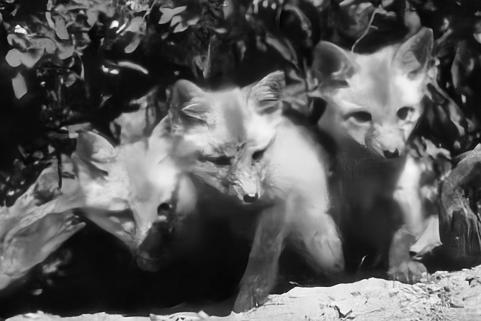
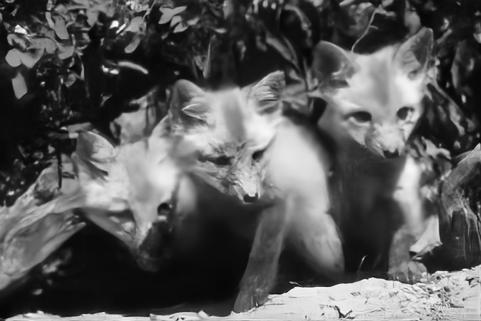
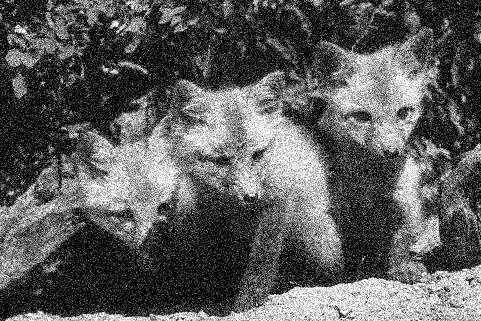
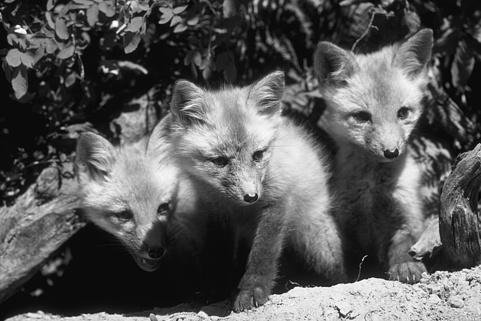

In [11]:
# denoise image with both models

from models import FFDNet, FFDNet_pretrained_grayscale
from models import DnCNN, DnCNN_pretrained
from skimage import io
from denoising_helpers import test_denoiser

sigma=40 # try different values of sigma
im_clean = io.imread('datasets/BSD68/test024.png').astype(np.float32)
im_noisy = im_clean + np.random.normal(0, sigma, im_clean.shape)

ffdnet = FFDNet_pretrained_grayscale(sigma)
dncnn  = DnCNN_pretrained(sigma)

outputs = list()

# Run DnCNN. We specify has_noise=True since we have already added noise to the image
out = test_denoiser(dncnn, im_noisy, None, has_noise=True)[0]
outputs.append( (out, 'dncnn output - PSNR = %f' % PSNR(out, im_clean)) )

# Run FFDNet. We set sigma_param=True since this network has a noise level parameter
out = test_denoiser(ffdnet, im_noisy, sigma, has_noise=True, sigma_param=True)[0]
outputs.append( (out, 'ffdnet output - PSNR = %f' % PSNR(out, im_clean)) )

outputs.append( (im_noisy, 'noisy input with sigma = %f' % (sigma)) )
outputs.append( (im_clean, 'clean image') )

vistools.display_gallery(unzip(outputs,0), unzip(outputs,1) )

We will repeat the experiment that we did before and compare the performance of DnCNN and FFDNet when varying the noise level. For DnCNN we compute the result with a network trained with the correct noise level $\sigma$ and with a fixed noise level $\sigma_0$. Analogously, for FFDNet we compute the result with a noise map having the correct value 
$\sigma$ and one having a fixed noise level $\sigma_0$.





<br/>
<br/>

**Attention:** For performance reasons, the variables `PSNR_dncnn_sigma0` and `PSNR_dncnn_sigma` of this block are re-used from the block: **"Stress tests on DnCNN: robustness to changes in $\sigma$"**, that was executed before.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 


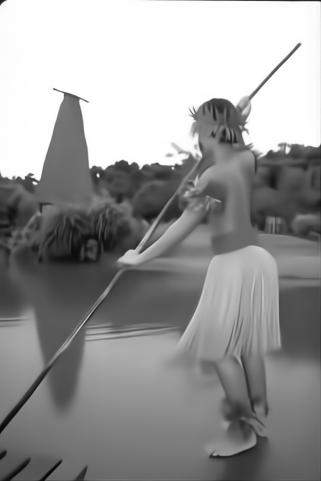
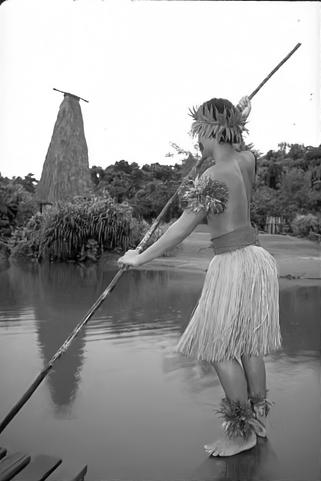
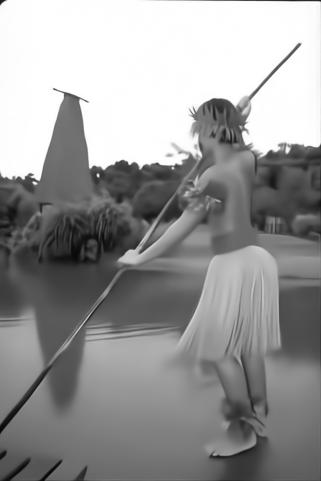
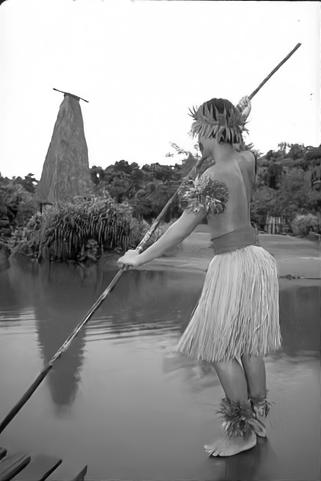
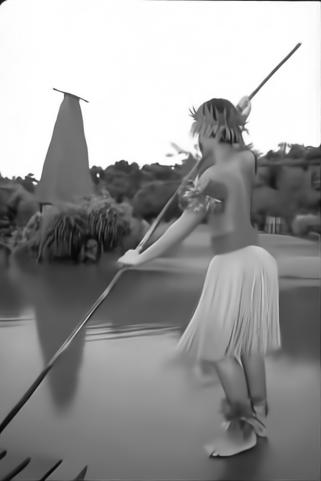
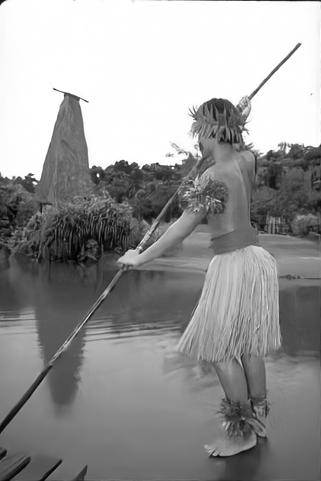
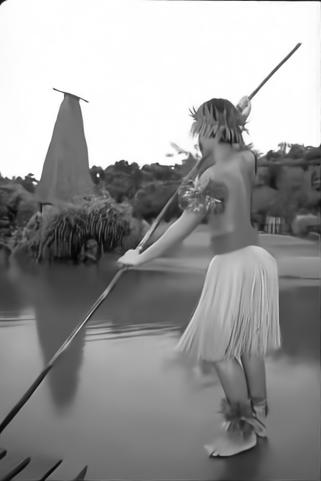
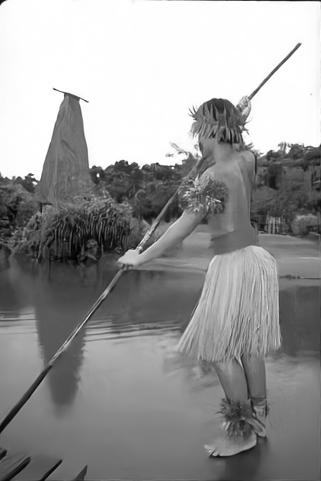
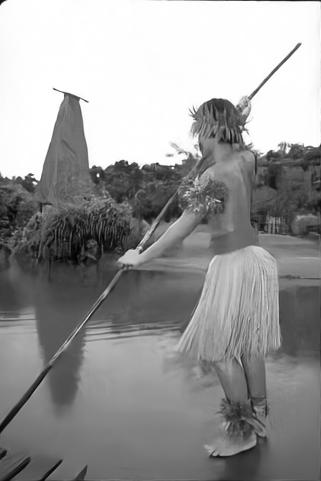
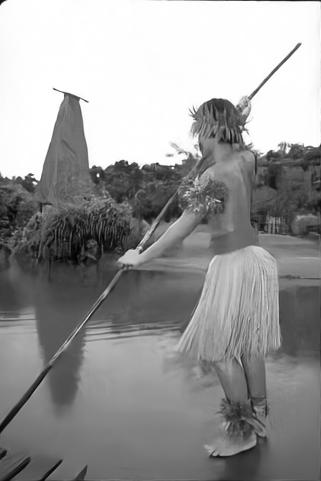
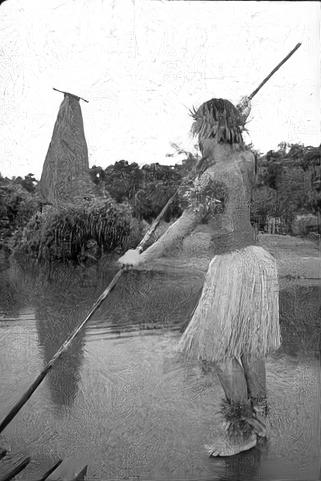
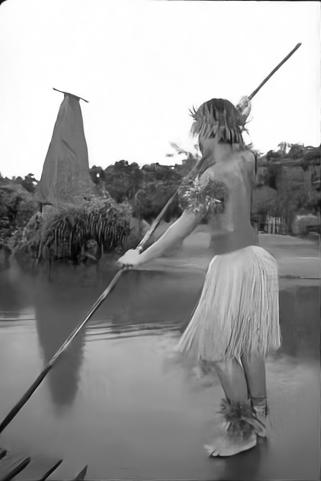
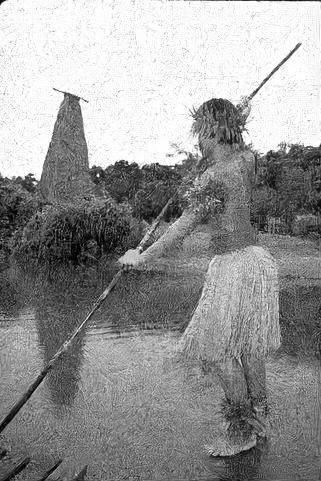
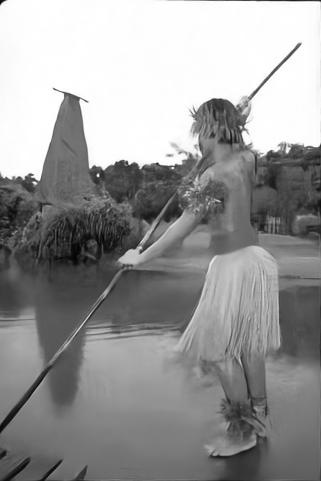
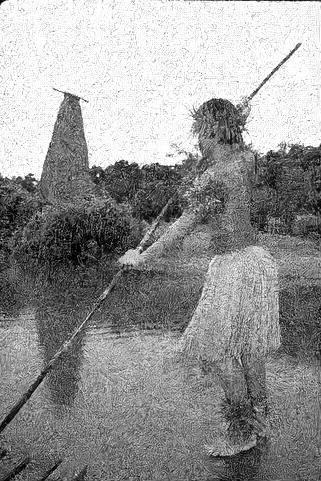
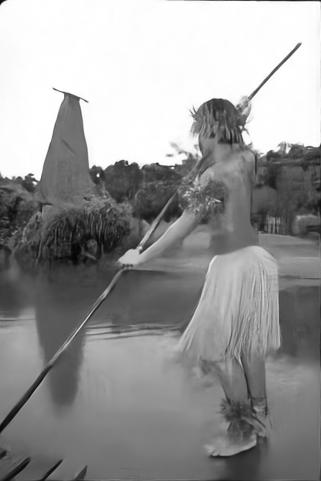
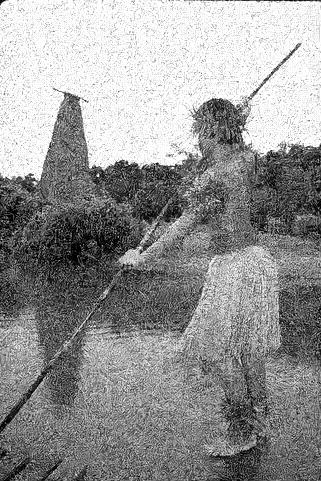
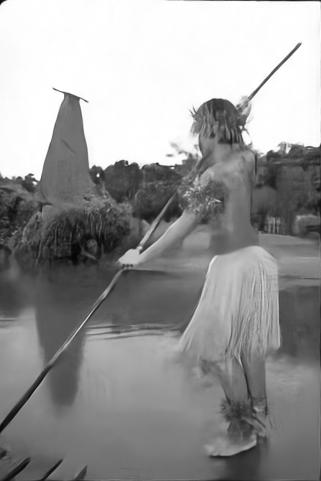
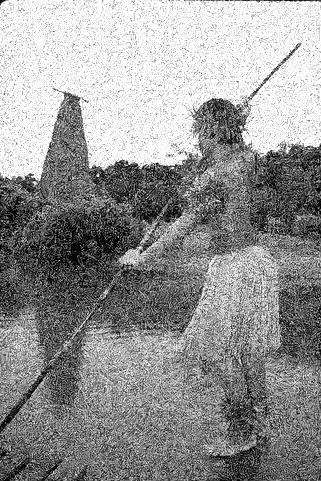
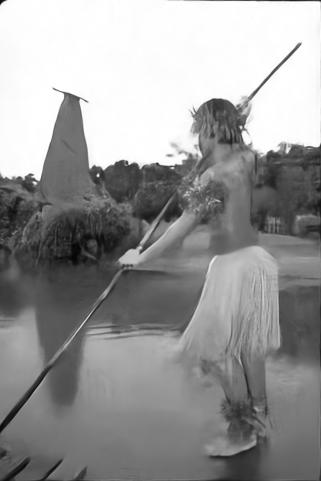
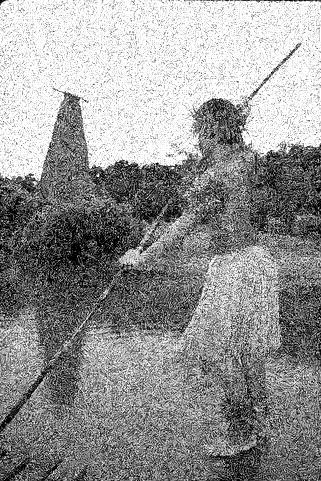
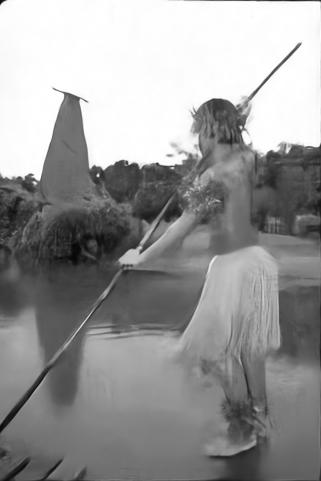
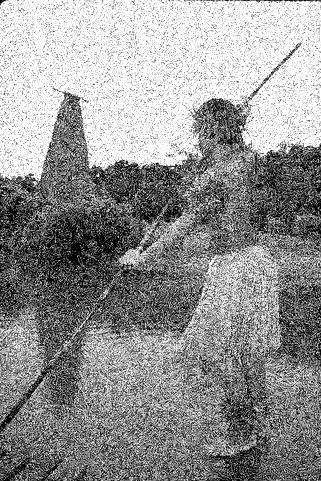
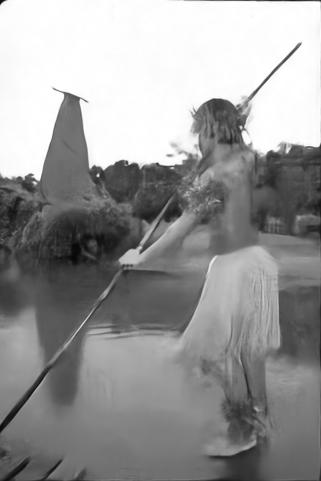
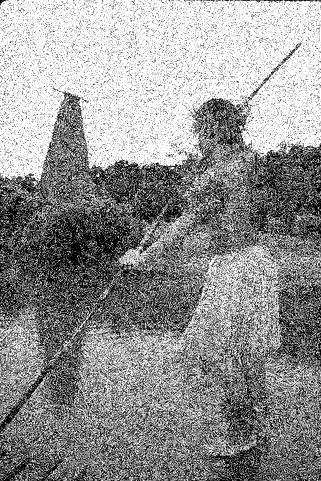
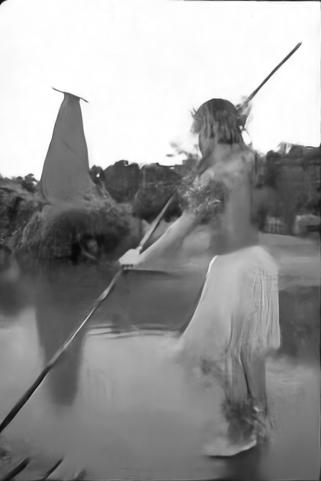
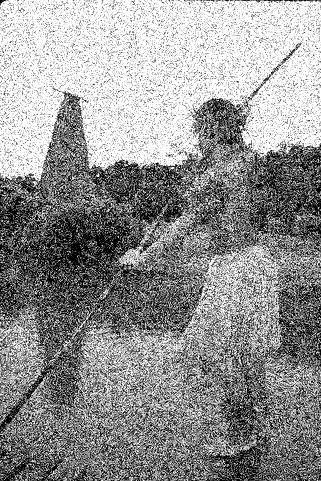
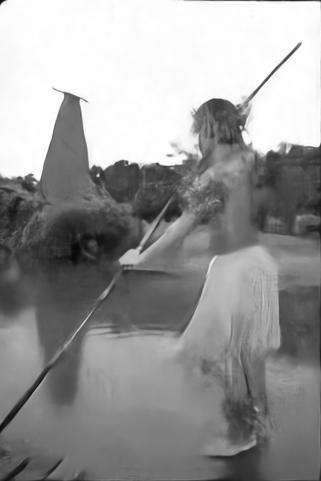

In [12]:
from models import DnCNN, DnCNN_pretrained
from models import FFDNet, FFDNet_pretrained_grayscale
from denoising_helpers import *
from skimage import io
from vistools import unzip

# load an image (change the number to test other images)
image = io.imread('datasets/BSD68/test002.png').astype(np.float32)

# set a noise level
sigma0 = 30

im_clean = image.astype('float32')
noise = np.random.normal(0, 1., im_clean.shape)

# load pre-trained DnCNN
dncnn_sigma0  =  DnCNN_pretrained(sigma0)
ffdnet = FFDNet_pretrained_grayscale(sigma0)

sigmas = np.linspace(10,75,14)  #sigmas = np.linspace(5,80,76)
#print(sigmas)

##############
### THE PSNR_dncnn_sigma0 and PSNR_dncnn_sigma VARIABLES ARE COMPUTED IN SECTION: 
###    Stress tests on DnCNN: robustness to changes in $\sigma$ 
##############

#PSNR_dncnn_sigma0  = np.zeros(len(sigmas))
#PSNR_dncnn_sigma   = np.zeros(len(sigmas))
PSNR_ffdnet_sigma0 = np.zeros(len(sigmas))
PSNR_ffdnet_sigma  = np.zeros(len(sigmas))

outputs = list()

# apply them to the image
for i, sigma in enumerate(sigmas):
    print('%d '%i, end='')
    
    # add noise
    im_noisy = im_clean + sigma * noise

    # denoise image with both DnCNN models
    dncnn_sigma = DnCNN_pretrained(sigma)
    #out_dncnn_sigma0 = test_denoiser(dncnn_sigma0, im_noisy, None, has_noise=True)[0]
    #out_dncnn_sigma  = test_denoiser(dncnn_sigma , im_noisy, None, has_noise=True)[0] 

    # denoise image with both FFDnet models
    out_ffdnet_sigma0 = test_denoiser(ffdnet, im_noisy, sigma0, has_noise=True, sigma_param=True)[0]
    out_ffdnet_sigma  = test_denoiser(ffdnet, im_noisy, sigma , has_noise=True, sigma_param=True)[0]
    
    #PSNR_dncnn_sigma0[i]  = PSNR(out_dncnn_sigma0 , im_clean)
    #PSNR_dncnn_sigma[i]   = PSNR(out_dncnn_sigma  , im_clean)
    PSNR_ffdnet_sigma0[i] = PSNR(out_ffdnet_sigma0, im_clean)
    PSNR_ffdnet_sigma[i]  = PSNR(out_ffdnet_sigma , im_clean)

    #outputs.append((out_dncnn_sigma0 , 'noise sigma = %4.1f - dncnn  sigma = %4.1f - PSNR = %5.2f' % (sigma, sigma0, PSNR_dncnn_sigma0 [i])))
    outputs.append((out_ffdnet_sigma0, 'noise sigma = %4.1f - ffdnet sigma = %4.1f - PSNR = %5.2f' % (sigma, sigma0, PSNR_ffdnet_sigma0[i])))
    #outputs.append((out_dncnn_sigma  , 'noise sigma = %4.1f - dncnn  sigma = %4.1f - PSNR = %5.2f' % (sigma, sigma , PSNR_dncnn_sigma  [i])))
    outputs.append((out_ffdnet_sigma , 'noise sigma = %4.1f - ffdent sigma = %4.1f - PSNR = %5.2f' % (sigma, sigma , PSNR_ffdnet_sigma [i])))
    
    
# show as a gallery
if len(outputs) < 80:
    vistools.display_gallery(unzip(outputs,0), unzip(outputs,1) )



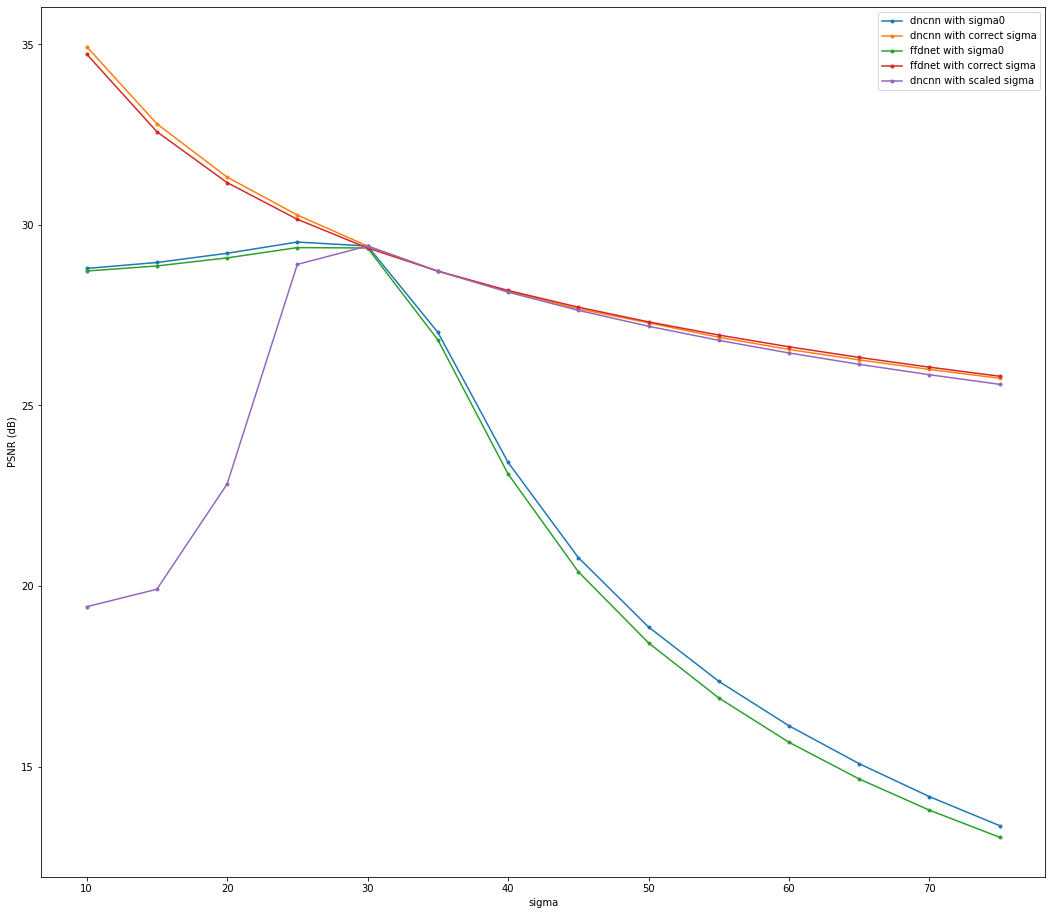

In [13]:
# Plot the PSNRs as a function of sigma

plt.figure(figsize=(18, 16))
plt.plot(sigmas, PSNR_dncnn_sigma0 , '.-', label='dncnn with sigma0')
plt.plot(sigmas, PSNR_dncnn_sigma  , '.-', label='dncnn with correct sigma')
plt.plot(sigmas, PSNR_ffdnet_sigma0, '.-', label='ffdnet with sigma0')
plt.plot(sigmas, PSNR_ffdnet_sigma , '.-', label='ffdnet with correct sigma')

plt.plot(sigmas, PSNR_dncnn_scaled  , '.-', label='dncnn with scaled sigma')
plt.legend(); plt.xlabel('sigma'); plt.ylabel('PSNR (dB)');

Note that the PSNR for FFDNet is only slightly higher than the one of DnCNN with the correct sigma, or the scaled DnCNN. The advantage of FFDNet is its efficiency.

# The choice of the loss

Our following experiments deal with the choice of the loss. There are several losses to choose from, and this choice has an impact on the results. [This paper](https://arxiv.org/abs/1511.08861) presents an empirical study of different losses for the application of denoising. 

We will investigate some properties of the $L_1$ and the squared $L_2$ losses. In addition to the Gaussian noise model that we have used so far, we will introduce a different type of noise that help to highlight some of the differences between these loss functions.

### Uniform salt and pepper noise

For simplicity of notation in the following, we will assume that the image range is $[0,1]$. The salt and pepper noise contaminates a random set of pixels of an image. A corrupted pixel can take the value 0 (black) or 1 (white), chosen randomly (hence the name salt and pepper). 

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f4/Noise_salt_and_pepper.png"/>

In our uniform salt and pepper noise a pixel is corrupted with probability $p$. The corrupted pixels are replaced with a value drawn from a uniform distribution in $[0,1]$. If we denote by $v(x)$ the corrupted pixel and $u(x)$ the clean pixel, the PDF of $v(x)$ given $u(x)$ is:

$$P(v(x)\,|\,u(x)) = (1-p)\delta_{u(x)}(v(x)) + p.$$

In practice with `numpy` we can corrupt an image with this noise with the following code:
```python
# binary mask of corrupted pixels (0 means corrupted)
mask = np.random.binomial(1, 1-p, im_clean.shape)

# image of uniform noise in [0, 1] (assuming image intensities are normalized to [0,1])
noise = np.random.uniform(0., 1., im_clean.shape)

# replace corrupted pixels with uniform noise
im_noisy = im_clean * mask + noise * (1 - mask)
```

<br>

We have implemented a data loader for training which currupts images with the uniform salt-and-pepper noise. The following code demonstrates its usage.



A minibatch of noisy patches:


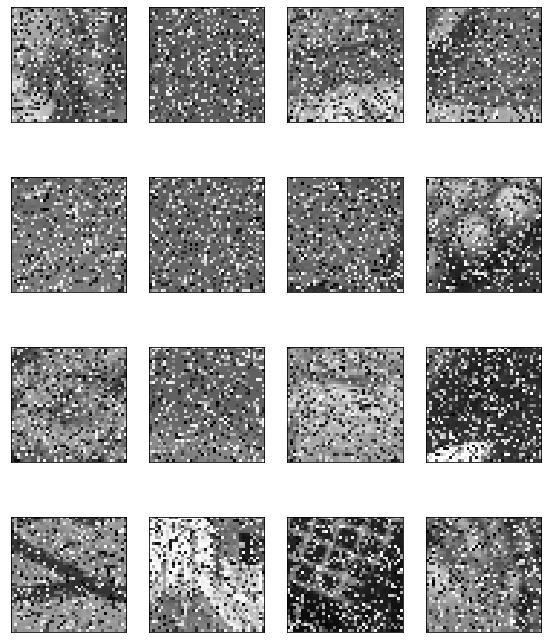



And the corresponding noiseless patches:


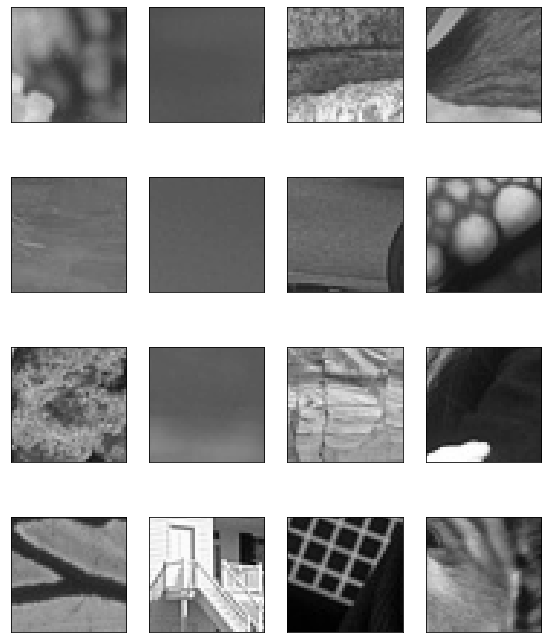

In [14]:
from denoising_dataloaders import train_val_denoising_dataloaders
import vistools

# noise level
p = 0.4

# create the data loader - note 'noise_type' argument
train_loader, val_loader = \
    train_val_denoising_dataloaders('./datasets/Train400/',
                                     noise_sigma=p,
                                     crop_size=40,
                                     train_batch_size=16,
                                     noise_type='uniform-sp')

# visualize first mini-batch
X, Y = list(train_loader)[0]

# this helper function displays the patches in the mini-batch
print('\n\nA minibatch of noisy patches:')
vistools.display_patches(X)

print('\n\nAnd the corresponding noiseless patches:')
vistools.display_patches(Y)

<font color='blue'>**Question 4.**  
1. Compute the cummulative distribution function (CDF) of $v\,|\,u$. Draw its graph, which will be useful for 3.
2. Compute the mean of the distribution.
3. Compute the median of the distribution. 
   Use the following definition for the median. The median of a random variable $V$ is defined as the value $m$ such that 

$$P(V \geq m) \geq 1/2\quad\text{and}\quad P(V\leq m)\geq 1/2.$$

4. Show that if $p < 1/2$, then the median $m$ of $v |u$ is $u$.

*Note: we are assuming that images intesities lie between [0,1] and can take any real value (i.e. they are not discretized).*</font>

noisy image > median


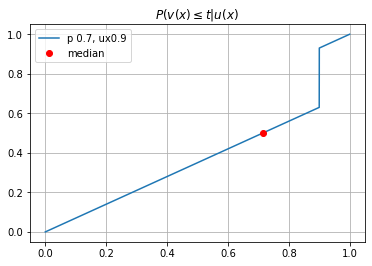

In [15]:
import numpy as np
import matplotlib.pyplot as plt
p = .7
ux = .9
x1 = np.linspace(0, ux-1e-12, 1000)
y1 = p*x1
x2 = np.linspace(ux, 1, 1000)
y2 = p*x2 + (1-p)
plt.plot(np.concatenate([x1,x2]), np.concatenate([y1,y2]))
plt.title("$P(v(x)\leq t | u(x)$")
plt.grid()

m1 = (p -0.5)/p
m2 = 1/(2*p)


if p<=0.5 or (1 - p*(ux-1) >= 0.5 and p*ux<0.5):
  print("median at discontinuity")
  plt.plot(ux,0.5, "ro")
else:
  if ux >= m2:
    print("noisy image > median")
    plt.plot(m2, 0.5, "ro")
  else:
    print("noisy image < median")
    plt.plot(m1, 0.5, "ro")

plt.legend([f"p {p}, ux{ux}", "median"])

<font color='red'>**ANSWER TO QUESTION 4**</font>

1. \begin{align}
P(v(x)\leq t | u(x)) &= \int_0^t(1-p)\delta_{u(x)}(v(x)) + p dv(x) &= tp + (1-p) \int_0^t \delta_{u(x)}(v(x))dv(x) \\
&= tp + \mathbb{1_{\{u(x)\leq t\}}(1-p)}
\end{align}

2. \begin{align}
\mathbb{E}(v(x) | u(x)) = \int_0^1 [(1-p)v(x)\delta_{u(x)}(v(x)) + pv(x)] dv(x)
&= \frac{p}{2} + (1-p)u(x)
\end{align}

3. 

The CdF is clearly discontinuous at $u(x)$, with a "jump" of $1-p$ in its value. By examining the graph and looking at its expression, we can see that there are two possibiliies for the median. 

* The median can be at the discontinuity:
  *  if $p \leq 0.5$, because the jump will cross the 0.5 probability.
  *  if $pu(x) + (1-p) \geq 0.5$ and $pu(x) \leq 0.5$
  
  Then $m=u(x)$
  
* If $p \geq 0.5$, the median can be computed analitically

$\underline{\text{If} \space m \leq u(x)}$

\begin{align}
P(v(x)\leq m|v(x)) = mp \geq \frac{1}{2} \\
P(v(x)\geq m|v(x)) = 1-mp \geq \frac{1}{2} \rightarrow \frac{1}{2} \geq mp \\ m = \frac{1}{2p} 
\end{align} \\

$\underline{\text{If} \space m \geq u(x)}$

\begin{align}
P(v(x)\leq m|v(x)) = mp + (1-p) \geq \frac{1}{2} \rightarrow m \geq \frac{p-\frac{1}{2}}{p}\\
P(v(x)\geq m|v(x)) = p - mp \geq \frac{1}{2} \rightarrow m \leq \frac {p-\frac{1}{2}}{p}\\
m = \frac{p-\frac{1}{2}}{p}
\end{align}

  We have two possible values for the median, depending on $u(x)$.

4. From the previous part, it's easy to show that if $p \leq 0.5$, then at the discontinuity the CdF will grow $1-p \geq 0.5$. Since the CdF is bounded in 1, if we're adding something bigger than $0.5$, it means that up to that point the value of the CdF was smaller than $0.5$. Then, the median happens at the discontinuity, the discontinuity being exactly at $u(x)$ (because it's caused by the delta / indicator function at $u$).

### Gaussian noise denoisers trained with $L_1$ and $L_2$ losses

We have trained our tiny DnCNN network with the MSE (or squared L2 loss) and the L1 loss. The following block does the training. We will skip this block, load the pretrained networks, and compare the results on a test image.

In [16]:
from models import DnCNN
from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel

sigma=30

# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False

# choose loss
loss_name = 'l1'
#loss_name = 'l2'

if training:
    # data
    trainloader, validationloader = train_val_denoising_dataloaders(
                                              './datasets/Train400/', 
                                               noise_sigma=sigma, crop_size=40, 
                                               train_batch_size=128)
    # network model
    dncnn = DnCNN(in_channels=1, out_channels=1, 
                  num_layers=7, features=13, kernel_size=3, residual=True)
    
    # run the training loop using chosen loss
    loss_fn = nn.L1Loss() if loss_name == 'l1' else nn.MSELoss()
    dncnn, losst, lossv = trainmodel(dncnn, loss_fn, trainloader, validationloader, 
                                     num_epochs=2000, save_every=500, loss_every=100,  
                                     learning_rate=0.01, weight_decay=0.00001,
                                     filename='pre-trained-tp2/tiny_DnCNN_%s_' % (loss_name))

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patc


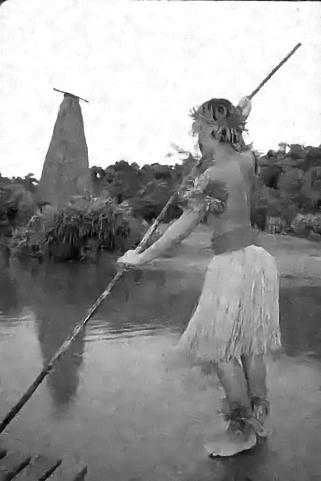
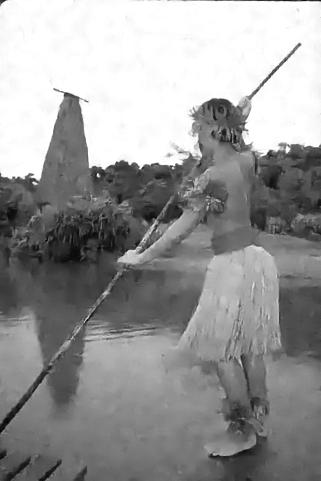
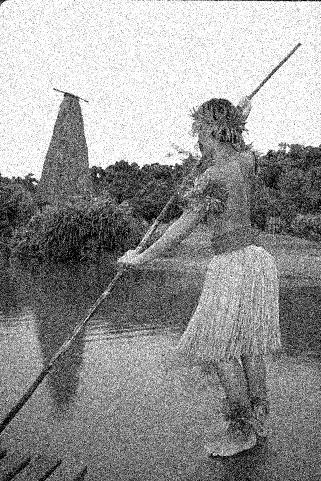
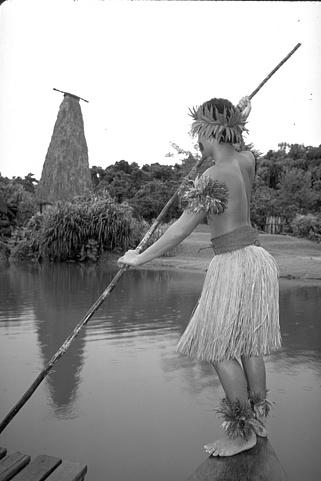

In [17]:
# denoise image with both models
from models import DnCNN
from skimage import io
from denoising_helpers import test_denoiser, PSNR
from vistools import unzip

sigma=30
im_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
im_noisy = im_clean + np.random.normal(0, sigma, im_clean.shape)

outputs = list()

net = torch.load('pre-trained-tp2/tiny_DnCNN_l2_2000.pt', map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'dncnn MSE loss - PSNR = %f' % PSNR(out, im_clean)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_l1_2000.pt', map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'dncnn l1 loss - PSNR = %f' % PSNR(out, im_clean)))

outputs.append((im_noisy, 'noisy input with sigma = %f' % (sigma)))
outputs.append((im_clean, 'clean image'))

# show as a gallery
vistools.display_gallery(unzip(outputs,0), unzip(outputs,1))

<font color='blue'>**Question 5.** Give a brief qualitative comparison of the two results.</font>

<font color='red'>**ANSWER TO QUESTION 5**</font>

Qualitatively the results look really simlar for both models. The model trained with L1 loss seems to produce a slightly smoother result, while in flat regions like the sky looks better, over some textures the L2 result looks slightly better.

In terms of the PSNR they are also really close, with the L2 model having a slightly higher score.

### Uniform salt-and-pepper noise denoisers trained with $L_1$ and $L_2$ losses

As before we will compare networks pretrained with this type of noise using $L_1$ and $L_2$ losses.

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patc


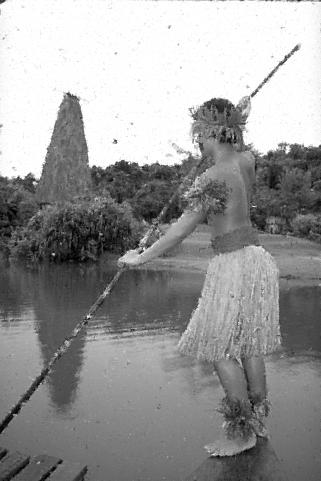
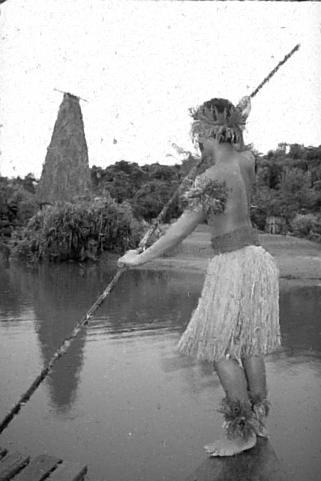
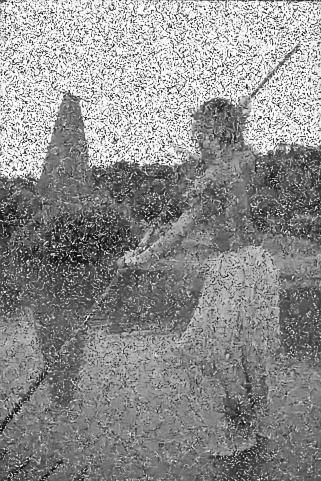
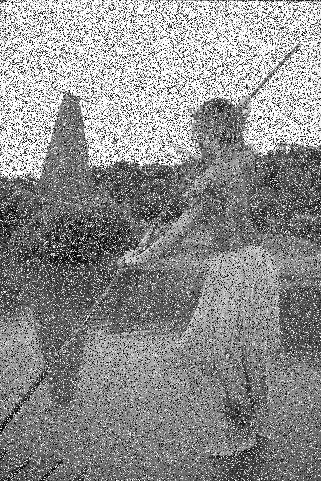
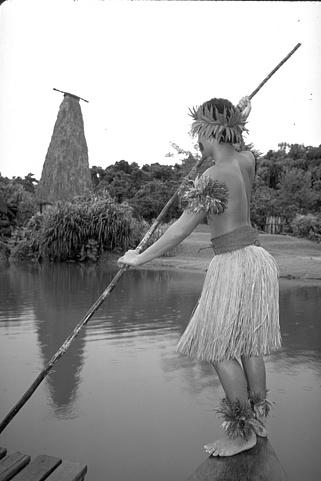

In [18]:
# denoise image with both models
from models import DnCNN
from skimage import io
from denoising_helpers import test_denoiser, PSNR
from vistools import unzip

p=0.4
im_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
mask = np.random.binomial(1, 1-p, im_clean.shape)
noise = np.random.uniform(0, 255., im_clean.shape)
im_noisy = im_clean * mask + noise * (1 - mask)

outputs = list()

net = torch.load('pre-trained-tp2/tiny_DnCNN_l1_usp_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'dncnn usp l1 loss - PSNR = %f' % PSNR(out, im_clean)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_l2_usp_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'dncnn usp l2 loss - PSNR = %f' % PSNR(out, im_clean)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_l2_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'dncnn gaussian MSE loss - PSNR = %f' % PSNR(out, im_clean)))

outputs.append((im_noisy, 'noisy input with p = %f' % (p)))
outputs.append((im_clean, 'clean image'))

vistools.display_gallery(unzip(outputs,0), unzip(outputs,1))

It seems that both losses performed decently for both types of considered noise. In the next lesson we will see that in a different training setup this choice of the loss is crucial.

---------------------------
[//]: # (© 2018 Gabriele Facciolo and Pablo Arias)
[//]: # (<div style="text-align:center; font-size:75%;"> Copyright © 2018 Gabriele Facciolo and Pablo Arias. All rights reserved.</div> )

#  Blind denoising and bias-free networks




[The following recent article](https://openreview.net/forum?id=r1gOn7h9UH) proposes a **blind image denoising network**:

*Sreyas Mohan, Zahra Kadkhodaie, Eero P. Simoncelli, Carlos Fernandez-Granda:
Robust And Interpretable Blind Image Denoising Via Bias-Free Convolutional Neural Networks. ICLR 2020*

**The article provides a enlightening perspective on the subject, and we recommend to read it**. One of its observations is that removing the bias terms from the denoising CNN architectures (BN and conv layers) allows to interpret the effect of the network with linear-algebra tools and also boosts generalization performance across noise levels.

The objective of this section is to corroborate the claim that bias-free networks are homogeneous and that this results in an improved generalization beyond the trained noise range.

<!--This entails many questions:-->
To this aim, we will:
* Check if a network without biases can denoise at all, and compare its performance with a similar network with biases.
<!--* How does it compare with an equivalent network with bias?-->
* Verify that the resulting network indeed generalizes to noise levels unseen during training.
* Evaluate how important it is to use a range of sigmas during the training. 


In order to train a noise blind network we must generate batches with random noise levels. To do so we set  `Randomnoiselevel=True` in the definition of the dataloader with  `denoising_dataloaders.train_val_denoising_dataloaders`. With this option the noise level of each patch is independently drawn in the range $[0,\sigma]$. The next block shows a sample of this data. 



A minibatch of noisy patches:


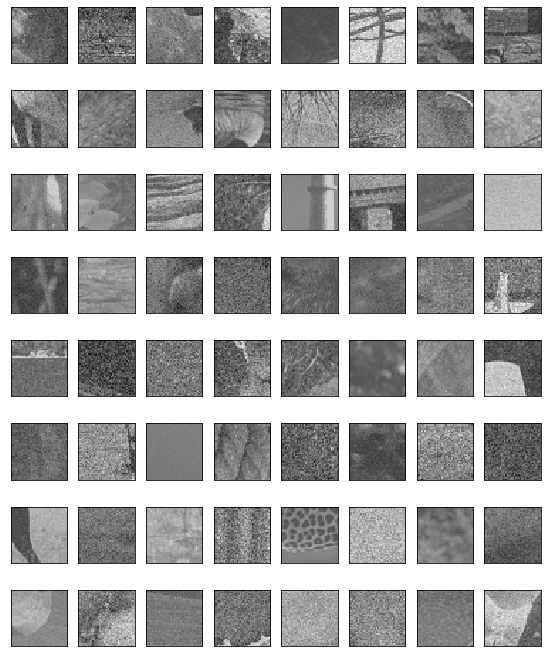



And the corresponding noiseless patches:


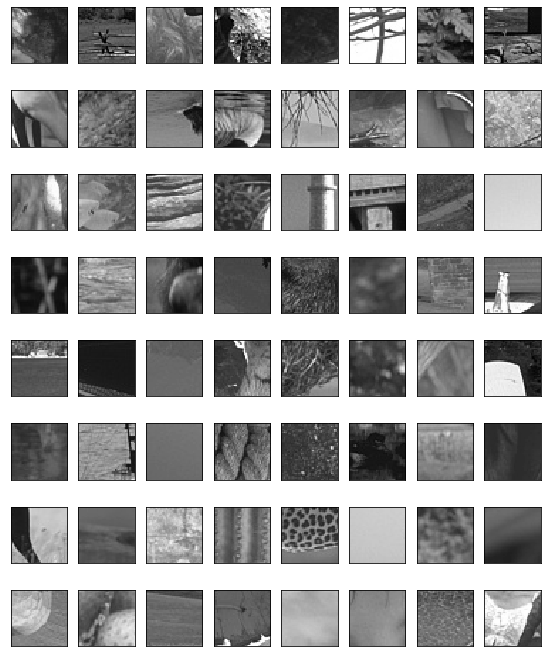

In [19]:

from denoising_dataloaders import train_val_denoising_dataloaders
import vistools

# noise level
sigma = 40

# dataloader with random noise
train_loader, val_loader = \
    train_val_denoising_dataloaders('./datasets/Train400/', 
                                    noise_sigma=sigma, crop_size=40, 
                                    train_batch_size=64, 
                                    Randomnoiselevel=True)

# visualize first mini-batch
X, Y = list(train_loader)[0]

# this helper function displays the patches in the mini-batch
print('\n\nA minibatch of noisy patches:')
vistools.display_patches(X)

print('\n\nAnd the corresponding noiseless patches:')
vistools.display_patches(Y)



Let's first train a blind denoising network. 
- As architecture we will use a **half DnCNN**, meaning that it has 64 features per layer (as DnCNN) but only 9 layers. 
- We set the noise range for training to $\sigma \in [0,40]$ (note that we set  `Randomnoiselevel=True` in the dataloader)
- Then train for 3000 epochs. **To save time we already pretrained it** using the code below. The resulting network is saved as: 

       pre-trained-tp2/blind_half_DnCNN_3000.pt

In [20]:
from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from torch import nn
from models import DnCNN

sigma=40

# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False

if training: 

    ##############################################
    # dataloader with random noise
    trainloader, validationloader = train_val_denoising_dataloaders(
                                            './datasets/Train400/', 
                                            noise_sigma=sigma, crop_size=40, 
                                            train_batch_size=180, 
                                            Randomnoiselevel=True)

    # network model TO COMPLETE
    Denoiser = DnCNN(in_channels=1, out_channels=1, 
                    num_layers=9,  
                    features=64,  
                    kernel_size=3, 
                    residual=True, bias=True)


    # loss
    loss = nn.L1Loss()


    # run the training loop
    Denoiser, loss, lossv, = trainmodel(Denoiser, loss, trainloader, validationloader, 
                                        num_epochs=3000, save_every=500, loss_every=50,  
                                        learning_rate=0.001, weight_decay=0.00001,
                                        filename=persistent_storage+'/blind_half_DnCNN_')

    # plot loss
    plt.semilogy(lossv, label='val')
    plt.semilogy(loss, label='train')
    plt.legend()



Let's now and train a **bias-free half DnCNN**. We have defined in `models.py` a `BF_DnCNN` model. 
`DnCNN` has biases in the convolutional layers and in the batch normalization layers, and all of them need to be removed. PyTorch does not allow to remove the bias from the `nn.BatchNorm2D` layer, thus we have completely remove the batch normalization in our `BF_DnCNN`.

With the following cell you can train a blind BF_DnCNN, with $\sigma \in [0,40]$. **A pre-trained network** is here:

       pre-trained-tp2/blind_half_DnCNN_BF_3000.pt


In [21]:
from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from torch import nn
from models import BF_DnCNN


# maximum of sigma range ([0,sigma_max]) 
sigma_max=40


# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False

if training: 


    ###############################################

    # dataloader with random noise
    trainloader, validationloader = train_val_denoising_dataloaders(
                                            './datasets/Train400/', 
                                            noise_sigma=sigma_max, crop_size=40, 
                                            train_batch_size=180, 
                                            Randomnoiselevel=True)

    # network model TO COMPLETE
    Denoiser = BF_DnCNN(in_channels=1, out_channels=1, 
                        num_layers=9,  
                        features=64,  
                        kernel_size=3, 
                        residual=True)


    # loss
    loss = nn.L1Loss()


    # run the training loop
    Denoiser, loss, lossv, = trainmodel(Denoiser, loss, trainloader, validationloader, 
                                        num_epochs=3000, save_every=500, loss_every=50,  
                                        learning_rate=0.001, weight_decay=0.00001,
                                        filename=persistent_storage+'/blind_half_BF_DnCNN_')

    # plot loss
    plt.semilogy(lossv, label='val bf')
    plt.semilogy(loss, label='train bf')
    plt.legend()



### Generalization to unseen noise levels

We will now evaluate the generalization capability of a blind BF_DnCNN to noise levels outside of the training range, and compare it with a DnCNN with biases.


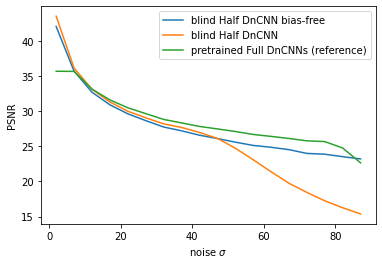

In [22]:
# evolution of the denoising performance during training
from denoising_helpers import test_denoiser, PSNR
from models import DnCNN_pretrained, DnCNN, BF_DnCNN
from skimage import io
from vistools import unzip


# choose the base directory for the trainings 
basedir='pre-trained-tp2'
#basedir=persistent_storage

# load clean image
img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)

# load blind networks
bf_hdncnn = torch.load(basedir+'/blind_half_BF_DnCNN_3000.pt')[0]
hdncnn    = torch.load(basedir+'/blind_half_DnCNN_3000.pt')[0]

# initialize lists for storing the psnrs
sigmas=[]
psnrs_bf_hdncnn=[]
psnrs_hdncnn=[]
psnrs_dncnn=[]

for sigma in range(2,90,5):

    img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

    # bias-free half-DnCNN
    out = test_denoiser(bf_hdncnn, img_noisy, None, has_noise=True)[0]
    psnrs_bf_hdncnn.append( PSNR(out, img_clean) )

    # half DnCNN with biases
    out = test_denoiser(hdncnn, img_noisy, None, has_noise=True)[0]
    psnrs_hdncnn.append( PSNR(out, img_clean) )

    # result of full DnCNN with trained weights
    dncnn = DnCNN_pretrained(sigma)
    out = test_denoiser(dncnn, img_noisy, None, has_noise=True)[0]
    psnrs_dncnn.append( PSNR(out, img_clean) )

    sigmas.append(sigma)

# plot results
plt.plot(sigmas,psnrs_bf_hdncnn, label='blind Half DnCNN bias-free')
plt.plot(sigmas,psnrs_hdncnn   , label='blind Half DnCNN')
plt.plot(sigmas,psnrs_dncnn    , label='pretrained Full DnCNNs (reference)')
plt.xlabel('noise $\sigma$')
plt.ylabel('PSNR')

plt.legend()

And this code should allow to analize the results. One might want to add the results obtained with an equivalent network trained with biases. 

24.954323876113882
22.110994345546914



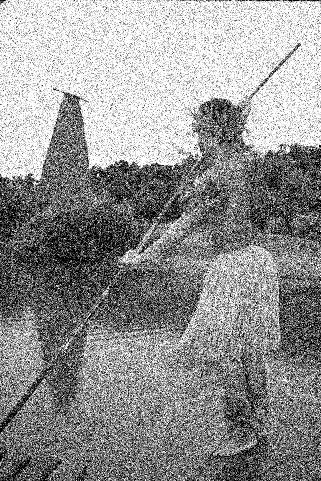
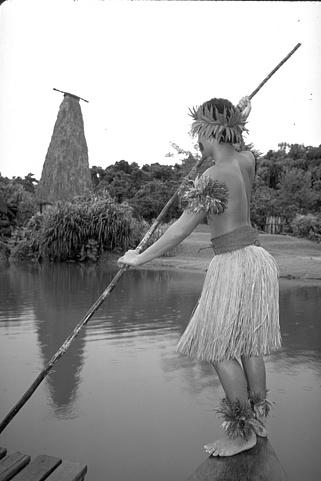
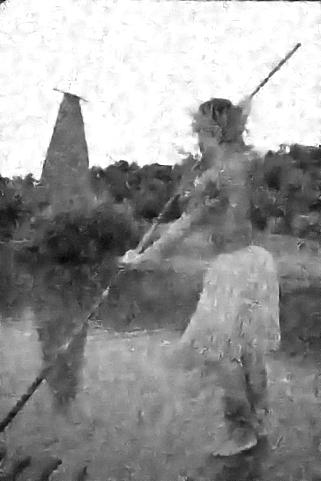
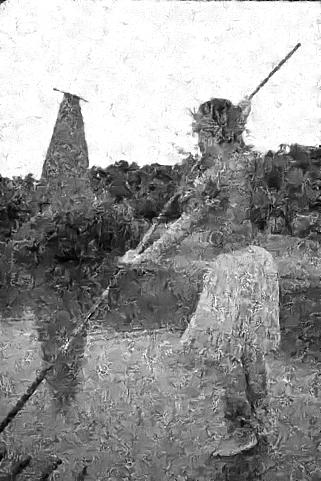
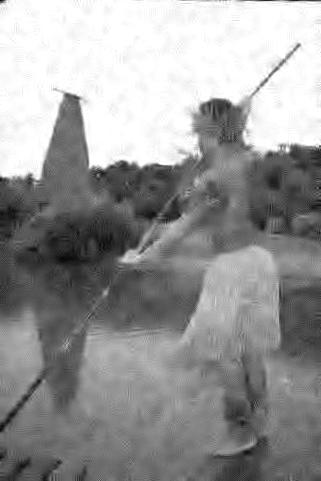
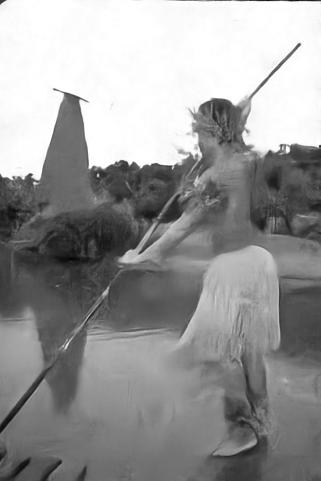

In [23]:
# evolution of the denoising performance during training
from denoising_helpers import test_denoiser, PSNR
from models import DCTlike, DnCNN_pretrained, DnCNN, BF_DnCNN
from skimage import io
from vistools import unzip



# choose the base directory for the trainings 
basedir='pre-trained-tp2'
#basedir=persistent_storage


# sigma outside the training range
sigma = 60 


# load an image and compute noisy one 
img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

# outputs list of pairs (image, text)
outs   = list()

# add noisy and clean images
outs.append( (img_noisy, 'noisy') )
outs.append( (img_clean, 'clean') )

# add results of blind_half_DnCNN_BF_3000
net = torch.load(basedir+'/blind_half_BF_DnCNN_3000.pt' )[0]
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'trained  BF blind DnCNN - %f (dB)' % ( PSNR(out, img_clean)) ) ) 
print (PSNR(out, img_clean))

# add results of blind_half_DnCNN_3000
net = torch.load(basedir+'/blind_half_DnCNN_3000.pt' )[0]
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'trained blind DnCNN - %f (dB)' % ( PSNR(out, img_clean)) ) ) 
print (PSNR(out, img_clean))

# add result of original dct
net = DCTlike(8, sigma, initializeDCT=True)
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'dct denoising - %f (dB)' % (PSNR(out, img_clean)) ) )

# add result of full DnCNN with trained weights
net = DnCNN_pretrained(sigma)
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'Full DnCNN - %f (dB)' % (PSNR(out, img_clean)) ) )


# show result as a gallery 
vistools.display_gallery(unzip(outs,0), unzip(outs,1))

### Homogeneity of bias-free networks

The positive homogeneity property says that the network $F$ verifies  
$$ F(\alpha x)/\alpha = F(x)$$
where $\alpha$ is a non-negative scalar. Bias-free networks with ReLUs have this property.

<font color='blue'>**Question 6.** Design an experiment that checks that **bias-free blind networks are homogeneous**. Analyze for several values of $\alpha$:
1.  the bias-free blind denoising network: `blind_half_DnCNN_BF_3000.pt`
2.  the (non bias-free) blind denoising one: `blind_half_DnCNN_3000.pt`
3.  the pretrained full DnCNN as a reference: `net = DnCNN_pretrained(sigma)`
4. explain the proposed experiment and the results obtained in the answer block below.
</font>

<font color='red'>**ANSWER TO QUESTION 6**</font>

The proposed experiment consists in for a fixed image and noise level, test the three models, viewing the output $\frac{F(\alpha x)}{\alpha}$ varying the value of $\alpha$ in a range $[\alpha_{min},.., 1, .., \alpha_{max}]$. 

We see that only for the bias-free network, the results (both visually and in PSNR) are the same across all the values for $\alpha$, moreover, for all $\alpha !=1$ the results are the same as using $\alpha=1$ which is computing $F(x)$. Then, we're able to validate that the bias-free architecture is homogeneuos, while the other two models are not.

Bias free results



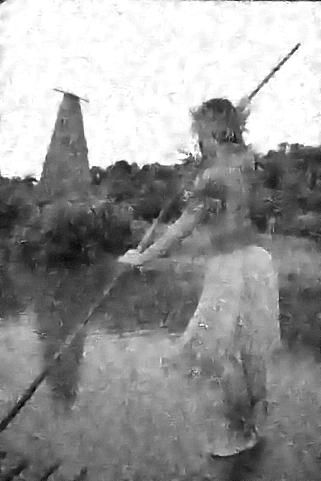
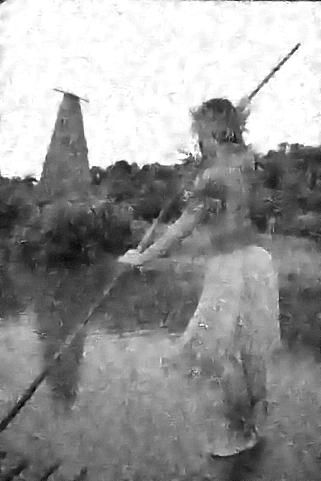
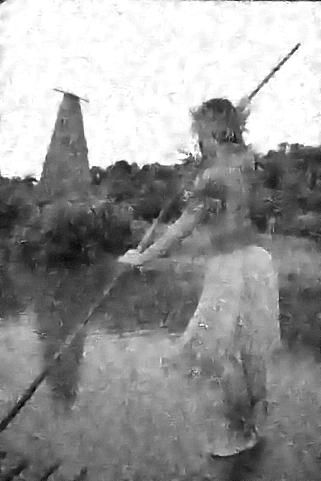
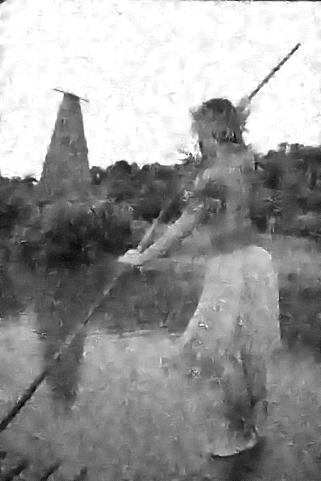
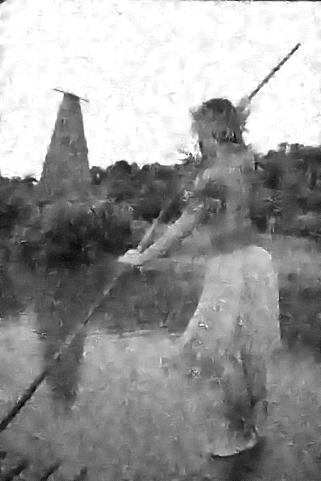

Blind results



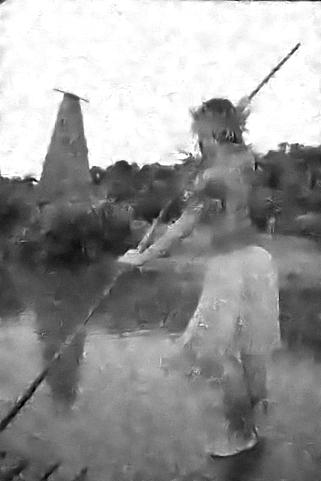
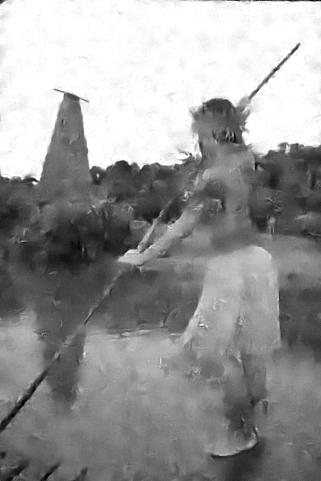
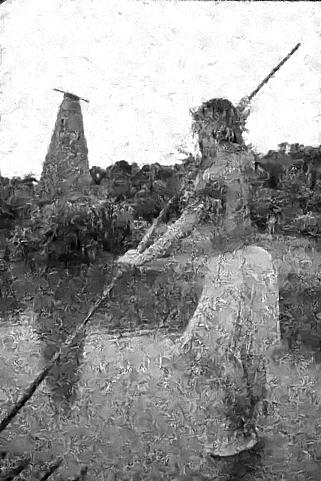
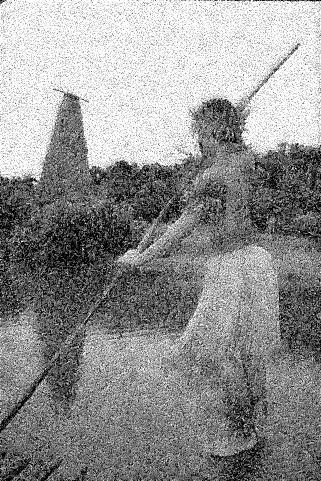
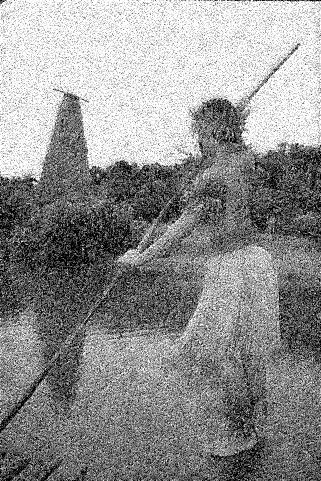

Full DnCNN results



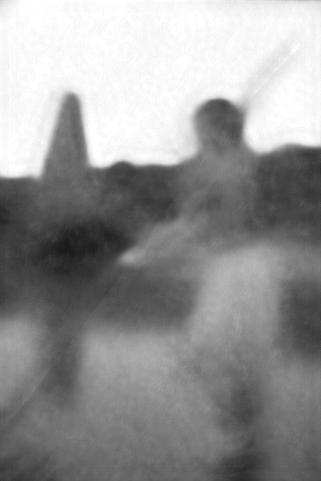
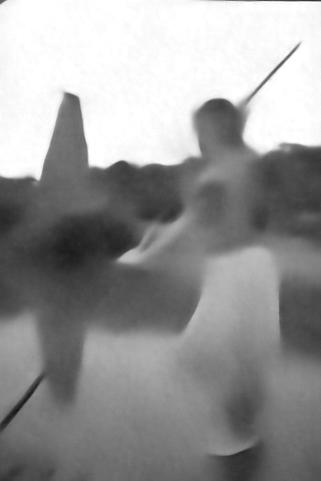
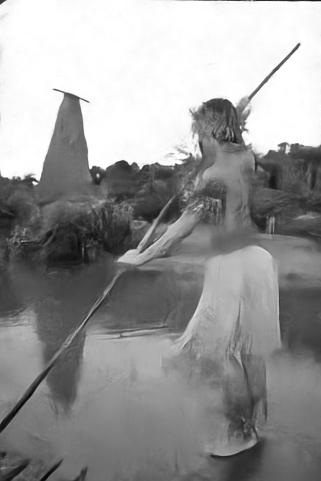
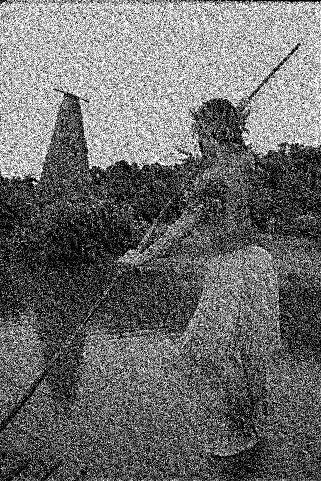
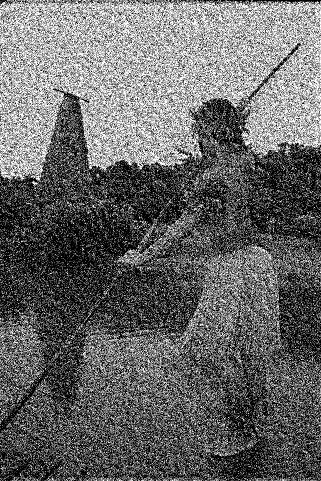

In [28]:
## WRITE HERE THE CODE TO ANSWER TO QUESTION 6
sigma = 60

# select test image
img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

# load networks
bf_hdncnn = torch.load(basedir+'/blind_half_BF_DnCNN_3000.pt')[0]
hdncnn    = torch.load(basedir+'/blind_half_DnCNN_3000.pt')[0]
dncnn = DnCNN_pretrained(sigma)

outs_bf   = list()
outs_dncnn = list()
outs_hdncnn = list()

for alpha in [.25, .5, 1, 5, 10]:
  scaled_img_noisy = img_noisy * alpha

  # bias-free half-DnCNN
  out = test_denoiser(bf_hdncnn, scaled_img_noisy, None, has_noise=True)[0] / alpha
  outs_bf.append((out, f"alpha {alpha} | bias-free blind DnCNN | {PSNR(out, img_clean)} (dB)"))

  # # half DnCNN with biases
  out = test_denoiser(hdncnn, scaled_img_noisy, None, has_noise=True)[0] / alpha
  outs_dncnn.append((out, f"alpha {alpha} | blind DnCNN | {PSNR(out, img_clean)} (dB)"))

  # # result of full DnCNN with trained weights
  dncnn = DnCNN_pretrained(sigma)
  out = test_denoiser(dncnn, scaled_img_noisy, None, has_noise=True)[0] / alpha
  outs_hdncnn.append((out, f"alpha {alpha} | full DnCNN | {PSNR(out, img_clean)} (dB)"))

print("Bias free results")
vistools.display_gallery(unzip(outs_bf,0), unzip(outs_bf,1))
print("Blind results")
vistools.display_gallery(unzip(outs_dncnn,0), unzip(outs_dncnn,1))
print("Full DnCNN results")
vistools.display_gallery(unzip(outs_hdncnn,0), unzip(outs_hdncnn,1))

### A non-blind bias-free DnCNN

We've seen that the bias-free half-DnCNN generalizes better to noise levels outside of the training range. We will now evaluate the generalization of a bias-free half-DnCNN trained for a specific noise level, instead of a noise range.

In the following block we train a **non-blind bias-free** network to noise with $\sigma=30$. A network pretrained for $\sigma=30$ is here:

      pre-trained-tp2/half_DnCNN_BF_30_3000.pt


In [25]:
from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from torch import nn
from models import BF_DnCNN


sigma=30


# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False

if training: 



    ###############################################

    # dataloader with random noise
    trainloader, validationloader = train_val_denoising_dataloaders(
                                            './datasets/Train400/', 
                                            noise_sigma=sigma, crop_size=40, 
                                            train_batch_size=180, 
                                            Randomnoiselevel=False)

    # network model TO COMPLETE
    Denoiser = BF_DnCNN(in_channels=1, out_channels=1, 
                        num_layers=9,  
                        features=64,  
                        kernel_size=3, 
                        residual=True)


    # loss
    loss = nn.L1Loss()


    # run the training loop
    Denoiser, loss, lossv, = trainmodel(Denoiser, loss, trainloader, validationloader, 
                                        num_epochs=3000, save_every=500, loss_every=50,  
                                        learning_rate=0.001, weight_decay=0.00001,
                                        filename=persistent_storage+'/half_BF_DnCNN_30_')

    # plot loss
    plt.semilogy(lossv, label='val bf')
    plt.semilogy(loss, label='train bf')
    plt.legend()


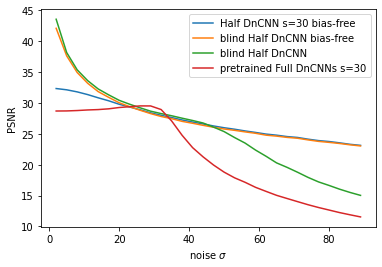

In [26]:
# evolution of the denoising performance during training
from denoising_helpers import test_denoiser, PSNR
from models import DCTlike, DnCNN_pretrained, DnCNN, BF_DnCNN
from skimage import io
from vistools import unzip




# choose the base directory for the trainings 
basedir='pre-trained-tp2'
#basedir=persistent_storage

bf_hdncnn_blind = torch.load(basedir+'/blind_half_BF_DnCNN_3000.pt')[0]
bf_hdncnn_s30   = torch.load(basedir+'/half_BF_DnCNN_30_3000.pt')[0]
hdncnn_blind    = torch.load(basedir+'/blind_half_DnCNN_3000.pt')[0]
dncnn_s30 = DnCNN_pretrained(30)

img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)

# intialize lists for psnrs
sigmas=[]
psnrs_bf_hdncnn_blind=[]
psnrs_bf_hdncnn_s30=[]
psnrs_hdncnn_blind=[]
psnrs_dncnn_s30=[]

for sigma in range(2,90,3):


    img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

    # bias-free half-dncnn trained with a noise range (blind training)
    out = test_denoiser(bf_hdncnn_blind, img_noisy, sigma, has_noise=True)[0]
    psnrs_bf_hdncnn_blind.append( PSNR(out, img_clean) )

    # half-dncnn with biases trained with a noise range (blind training)
    out = test_denoiser(hdncnn_blind, img_noisy, sigma, has_noise=True)[0]
    psnrs_hdncnn_blind.append( PSNR(out, img_clean) )

    # bias-free half-dncnn trained for noise with sigma = 30
    out = test_denoiser(bf_hdncnn_s30, img_noisy, sigma, has_noise=True)[0]
    psnrs_bf_hdncnn_s30.append( PSNR(out, img_clean) )

    # full DnCNN with trained weights for sigma = 30
    out = test_denoiser(dncnn_s30, img_noisy, sigma, has_noise=True)[0]
    psnrs_dncnn_s30.append(PSNR(out, img_clean))

    sigmas.append(sigma)


# plot results
plt.plot(sigmas, psnrs_bf_hdncnn_s30  , label='Half DnCNN s=30 bias-free')
plt.plot(sigmas, psnrs_bf_hdncnn_blind, label='blind Half DnCNN bias-free')
plt.plot(sigmas, psnrs_hdncnn_blind   , label='blind Half DnCNN')
plt.plot(sigmas, psnrs_dncnn_s30      , label='pretrained Full DnCNNs s=30')
plt.xlabel('noise $\sigma$')
plt.ylabel('PSNR')

plt.legend()

<font color='blue'>**Question 7.** The bias-free network trained for $\sigma_0 = 30$ generalizes well to values of $\sigma > \sigma_0$, but not for values $\sigma < \sigma_0$. We observed a similar behaviour in the section "*Stress test on DnCNN: affine scalings*". In that case, it was for a network (with biases) which was applied to a scaled version of the input $\alpha u + \beta$, where the scaling $\alpha = \sigma_0/\sigma$ was computed to match the noise level of the network $\sigma_0$. $\beta$ was added to preserve the average value of the input image, but is not important and we can ignored it. 


Explain why bias-free networks show a similar behaviour to the one we observed when applying a network with biases to a scaled input $F_{\sigma_0}(\alpha u)/\alpha$ with $\alpha = \sigma_0/\sigma$.
</font>

While we see a similar behavior, the phenomenon behind of it it's not exactly the same. In the network with biases we had two issues: the first one was getting inputs not expected by the biases of the network, causing the output to "explode". The second one, is the same issue that is affecting the bias-free network, which is going to be explained in this section.

Note that in a bias-free network, we don't have the problem of "exploding" outputs due to the absence of biases. The output, as was verified empirically, just gets multiplied by the same factor that multiplied the input. However, this is not enough to build a model trained on a single SNR (which is equivalent as a single value of $\sigma$), to all possible SNRs. In fact, it's able to generalize only to $\sigma \geq \sigma_0$.

If we analyse the examples that were saw during training in terms of SNR, we can understand why the model cannot generalize to lower noise levels. Let's suppose we trained the model for $\sigma_0=10$, and then use it for $\sigma=50$. Assume we are denoising a patch with contrast 100 in the high noise image, this is "equivalent" to a SNR of $2$. It's expected to have observed a similar patch during training, because that would imply a contrast of $20$, so the network "knows" how to denoise that patch. Assume now that we want to denoise an image with less noise, for example $\sigma=2$, and the same patch with contrast 100. This give us a SNR of $50$, to find the same SNR on the training examples we're required to have a contrast of $500$. Now it's obvious that since natural images are bounded between $[0, 255]$, we don't have that kind of patch in the training set, so the network wasn't trained to handle that case, and the performance will be worse. 